# <span style='font-family:"Times New Roman"'> <span styel=''>**NON-SMALL CELL LUNG CANCER ANALYSIS**

*Emile Cohen*
    
*June 2020*

**Goal**: In this notebook, we want to understand what makes Colorectal Cancer a textbook case for the patterns we saw, and what are the major subcohorts that drive the signal.

---

In [77]:
%run -i '../../../../../utils/setup_environment.ipy'

import warnings
warnings.filterwarnings('ignore')
from scipy.stats import fisher_exact, ranksums, chi2, norm
from statsmodels.sandbox.stats.multicomp import multipletests
import matplotlib.gridspec as gridspec
import pickle

data_path = '../../../../../data/'
data_wgd = data_path + 'impact-facets-tp53/processed/wgd/'
data_no_wgd = data_path + 'impact-facets-tp53/processed/no_wgd/'

Setup environment... done!


<span style="color:green">✅ Working on **mskimpact_env** conda environment.</span>

## Interesting functions

In [78]:
from functools import reduce

def get_hotspots(df: pd.DataFrame, Sample_Type: str, group: list = None, group_type:str = None):
    data = df[df['Sample_Type'] == Sample_Type]
    
    if group and group_type:
        data = data[data[group_type].isin(group)]

    data_1 = get_groupby(data,'tp53_spot_1', 'count'); data_2 = get_groupby(data,'tp53_spot_2', 'count'); data_3 = get_groupby(data,'tp53_spot_3', 'count') ; data_4 = get_groupby(data,'tp53_spot_4', 'count') ; data_5 = get_groupby(data,'tp53_spot_5', 'count') 
    series_data = [data_1,data_2,data_3,data_4,data_5]

    df_merged = reduce(lambda  left,right: pd.merge(left,right,left_index=True, right_index=True,
                                                how='outer'), series_data).fillna(0)

    df_merged.columns = ['count_1', 'count_2', 'count_3', 'count_4', 'count_5']
    df_merged['total'] = df_merged.sum(axis=1)
    df_merged = df_merged.sort_values(by='total', ascending=False)

    df_merged = df_merged.drop('nan')
    
    return df_merged

def get_hotspot_frac(df: pd.DataFrame, group_type:str = None, group: list = None, nb = 10):
    if group_type and group:
        df = df[df[group_type].isin(group)]
    result = [['spot', '#', 'frac']]
    for spot in get_groupby(df, 'tp53_spot_1', 'count').sort_values(by='count', ascending=False).head(nb).index.tolist():
        result.append([spot,df[df['tp53_spot_1'] == spot].frac_genome_altered.shape[0], df[df['tp53_spot_1'] == spot].frac_genome_altered.median()])

    return pd.DataFrame(result)


def boxplot_sampletype(df: pd.DataFrame, group:str, palette, order, metrics: str, figsize= (10,3), title: str = '', title_font: int=12, xlim=[0,1]):
    fig=plt.figure(figsize=figsize)
    ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)

    sns.boxplot(y=metrics, x=group,data=df,ax=ax, dodge=False,order=order, palette=palette).set_title(title, weight='bold', fontsize=title_font)
    
    groupby_ = get_groupby(df,group, 'count')
    groupby_ = groupby_.T
    for mut in mutation_list:
        if mut not in groupby_.columns:
            groupby_[mut] = 0
    groupby_ = groupby_.T
    
    labels = []
    for element in order:
        labels.append(element + '\n('+ str(groupby_.loc[element].values[0])+')')
    
    
    
    ax.set_xticklabels(labels)
    style(ax)
    ax.set_ylim(xlim)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    return fig, ax


# Let's give a look at medians and statistics

def get_statistics(df: pd.DataFrame, group:str, metrics: str, group_list: list):
    group_1 = df[df[group] == group_list[0]][metrics]
    group_2 = df[df[group] == group_list[1]][metrics]

    median_1 = group_1.median()
    median_2 = group_2.median()

    statistic, p_value = ranksums(group_1.dropna().values,group_2.dropna().values)
    
    results = [['', 'size', metrics],
               [group_list[0], group_1.shape[0], median_1],
               [group_list[1], group_2.shape[0], median_2],
               ['', 'Statistics', 'p-value'],
               ['', statistic, p_value]]


    return pd.DataFrame(results)

def get_major_codrivers(master: pd.DataFrame, maf: pd.DataFrame, head:int = 10, tp53=False):
    samples = master.Tumor_Id.tolist()
    if tp53:
        maf_filtered = maf[maf.Tumor_Sample_Barcode.isin(samples)][maf['driver'] == True]
    else:
        maf_filtered = maf[maf.Tumor_Sample_Barcode.isin(samples)][maf['driver'] == True][maf['Hugo_Symbol'] != 'TP53']
    h = pd.DataFrame(maf_filtered[['Hugo_Symbol']].groupby(['Hugo_Symbol']).size())
    h.columns = ['count']
    h = h.sort_values(by='count', ascending=False).head(head)
    
    return(h)

def create_co_drivers_table(master: pd.DataFrame, group_type:str,  group_1: str, group_2: str):
    master_group_1 = master[master[group_type] == group_1]
    co_drivers_group_1 = get_major_codrivers(master=master_group_1,
                        maf=maf_cohort_nowgd,
                       head=100)
    co_drivers_group_1['proportion_1'] = co_drivers_group_1.apply(lambda x: 100* round(x['count'] / co_drivers_group_1.sum().values[0], 4), axis=1)
    
    master_group_2 = master[master[group_type] == group_2]
    co_drivers_group_2 = get_major_codrivers(master=master_group_2,
                        maf=maf_cohort_nowgd,
                       head=100)
    co_drivers_group_2['proportion_2'] = co_drivers_group_2.apply(lambda x: 100* round(x['count'] / co_drivers_group_2.sum().values[0], 4), axis=1)
    
    co_drivers_groups = pd.merge(co_drivers_group_1, co_drivers_group_2, on='Hugo_Symbol')
    co_drivers_groups['proportion_1'] = - co_drivers_groups['proportion_1']
    
    return co_drivers_groups



## Master Definition and Filtering

In [79]:
cancer = 'Non-Small Cell Lung Cancer'

In [80]:
master_no_wgd = non_wgd_load_and_cut(data_path + 'impact-facets-tp53/processed/no_wgd/master_no_wgd.pkl')
master_wgd = pd.read_pickle(data_path + 'impact-facets-tp53/processed/wgd/master_wgd.pkl')

master_no_wgd_cancer = master_no_wgd[master_no_wgd['Cancer_Type'] == cancer]
master_wgd_cancer = master_wgd[master_wgd['Cancer_Type'] == cancer]

maf_cohort_nowgd = pd.read_csv(data_path + 'impact-facets-tp53/processed/no_wgd/maf_cohort_nowgd.txt', sep='\t').drop('Unnamed: 0', axis=1)
maf_cohort_wgd = pd.read_csv(data_path + 'impact-facets-tp53/processed/wgd/maf_cohort_wgd.txt', sep='\t').drop('Unnamed: 0', axis=1)

# What makes Colorectal Cancer a TextBook Case?

## WGD Proportion

Non-Small Cell Lung Cancer is one of the biggest cancer types in our cohort. It is the fourth cancer in term of WGD proportion with an average proportion of WGD - around 42%
<img src="wgd_proportion.png" width=700 length=700>

## Cancer Panel

* NSCLC is the third most represented cancer in MSK-Impact Cohort.
* Slightly enriched for Primary Samples
* In comparison with other cancer types, Non-Small Cell Lung Cancer is not particularly enriched nor depleted for a tp53 subgroup.

<img src="nscl_header.png" width=700 length=700>
<img src="nscl_panel.png" width=1000 length=700>

## Genome Instability

Non-Small Cell Lung Cancer Cancer shows a significant difference in Genome Instability between TP53 Mono-Allelic and Bi-Allelic subgroups - and has a lot of samples in both groups.
<img src="pancancer_gi.png" width=1000 length=600>

In the TP53 subgroup Pan Cancer plot that follows, we can see 3 important signals:
* The GI difference between *0_HETLOSS* and *1_WILD_TYPE*, two likely mono-allelic subgroups
* *1_WILD_TYPE* GI is very low compared to other subgroups
* Bi Allelic Subgroups - *>=1_LOSS* and *>=1_cnLOH* - have higher GI  than other subgroups and the difference is significant




<img src="pancancer_gi_sub_b.png" width=1000 length=600>



# WGD Part

## Subgroup Proportion

<img src="pre_prop.png" width=1000 length=600>
<img src="mut_loh_prop.png" width=1000 length=600>

2 main key points:
* No enrichment in Pre-WGD TP53 Bi-Allelic for NSCLC
* Enrichment in tp53 mutation and TP53 LOH samples

## Very High Genome Instability

<img src="pancancer_gi_wgd.png" width=1000 length=600>

# Non WGD Part - Cancer Investigation
In this section, our goal is to find subcohorts that lead the signals observed. Here are the different subcohort we will create:
* Hotspot Analysis: splitting on 273 / 248 / 175 / Missense / Truncated / In Frame
* CCF Analysis
* SNV/INDEL Analysis

## Hotspot Analysis
In this section, we cut our cohort to only keep samples with exactly one TP53 mutation, for simplicity.

In [8]:
master_hotspot = master_no_wgd_cancer[master_no_wgd_cancer['tp53_count'] == 1]

In [9]:
get_hotspot_frac(df=master_hotspot,
                group_type=None,
                group=None)

,0,1,2
0,spot,#,frac
1,nan,61,0.373
2,248,26,0.409
3,273,20,0.3145
4,158,19,0.301
5,245,15,0.377
6,175,15,0.39
7,157,13,0.427
8,179,12,0.479
9,280,10,0.317


### Entire Cohort

,count
tp53_vc_group_1,
missense,296
truncated,202
hotspot,30
248,26
273,20
175,14
in_frame,10


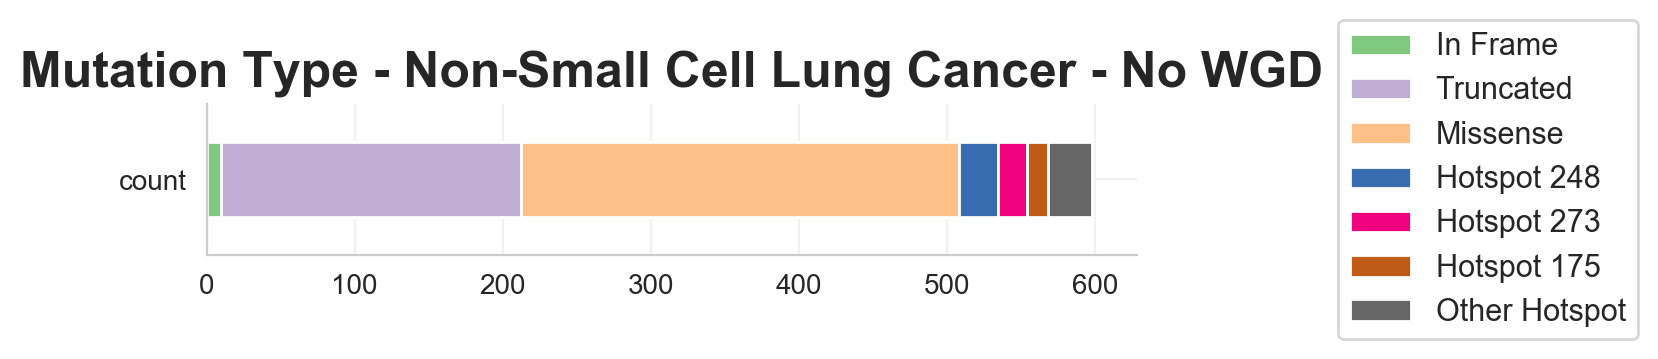

In [13]:
h = get_groupby(master_hotspot,'tp53_vc_group_1', 'count').sort_values(by='count', ascending=False)
display(h)

h = h.T
h = h[mutation_list]
fig = plt.figure(figsize=(6,1))
ax = plt.subplot()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

h_plot = h.plot(kind = 'barh', stacked=True, yticks=[], ax=ax, colormap="Accent")
ax.legend(['In Frame', 'Truncated', 'Missense', 'Hotspot 248','Hotspot 273','Hotspot 175', 'Other Hotspot'],loc='center left', bbox_to_anchor=(1.2, 0.5), fontsize=11)
ax.set_title('Mutation Type - {} - No WGD'.format(cancer), weight='bold', fontsize=18)

plt.show()

* **NSCLC has a very small proportion of hotspots.**

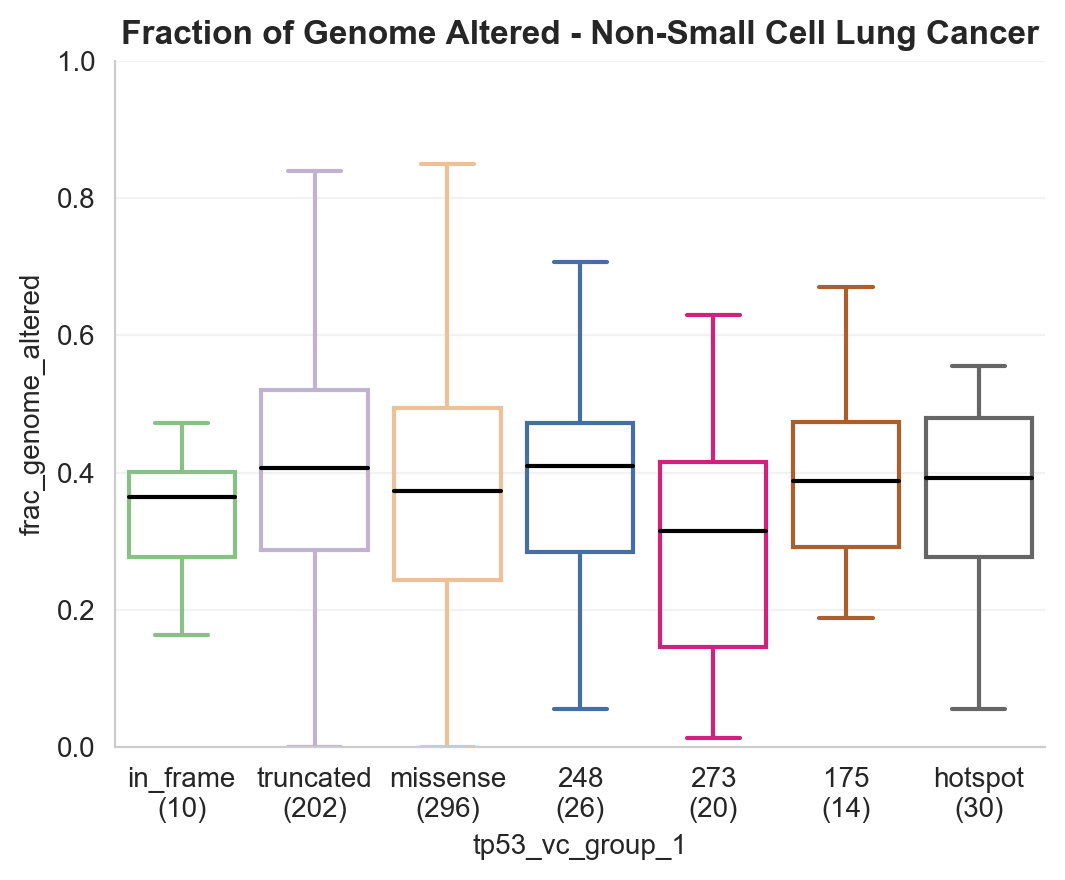

In [10]:
fig, ax = boxplot_sampletype(df=master_hotspot,
                  group='tp53_vc_group_1',
                  palette=mutation_palette,
                  order=mutation_list,
                  metrics='frac_genome_altered',
                  figsize=(6,10),
                  title='Fraction of Genome Altered - {}'.format(cancer),
                  xlim=[0,1])
plt.show()

* **Once more, it seems that 273 hotspot leads to lower GI**

### TP53 Residual Subgroups

In [34]:
print('Number of Bi Allelic samples (with 1 mut): ' + str(master_hotspot[master_hotspot['tp53_res_group'] == 'no_tp53_res'].shape[0]))
print('')
print('Number of  TP53 Residual samples (with 1 mut): ' + str(master_hotspot[master_hotspot['tp53_res_group'] == 'tp53_res'].shape[0]))



Number of Bi Allelic samples (with 1 mut): 497

Number of  TP53 Residual samples (with 1 mut): 62


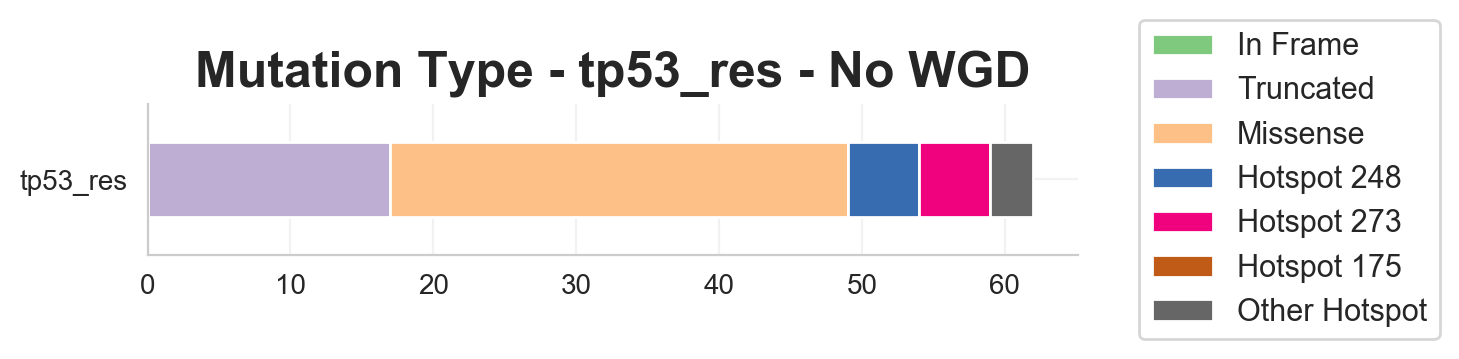

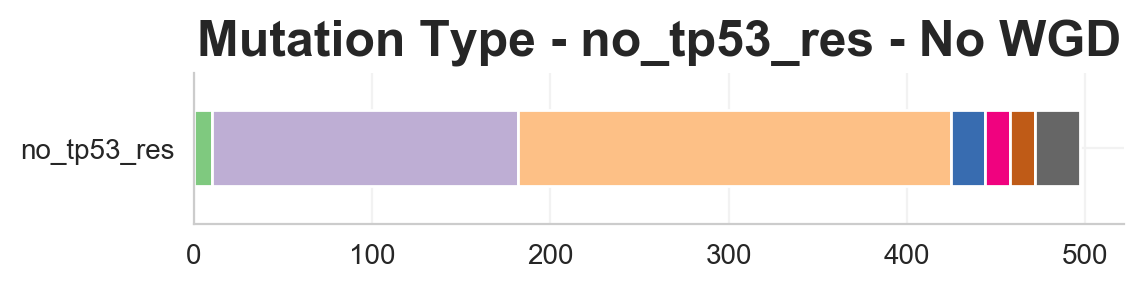

,tp53_res
tp53_vc_group_1,
missense,32
truncated,17
248,5
273,5
hotspot,3
,no_tp53_res
tp53_vc_group_1,
missense,243
truncated,172


In [41]:
total_df = []
for group in ['tp53_res', 'no_tp53_res']:
    h = get_groupby(master_hotspot[master_hotspot['tp53_res_group'] == group], 'tp53_vc_group_1', group).sort_values(by=group, ascending=False)
    total_df.append(h)
    
    h=h.T
    
    for mut in mutation_list:
        if mut not in h.columns:
            h[mut] = 0

    h = h[mutation_list]
    fig = plt.figure(figsize=(6,1))
    ax = plt.subplot()

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    h_plot = h.plot(kind = 'barh', stacked=True, yticks=[], ax=ax, colormap="Accent")
    if group == 'tp53_res':
        ax.legend(['In Frame', 'Truncated', 'Missense', 'Hotspot 248','Hotspot 273','Hotspot 175', 'Other Hotspot'],loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=11)
    else: ax.get_legend().remove()
    ax.set_title('Mutation Type - {} - No WGD'.format(group), weight='bold', fontsize=18)

    plt.show()

display_side_by_side(total_df[0],total_df[1])

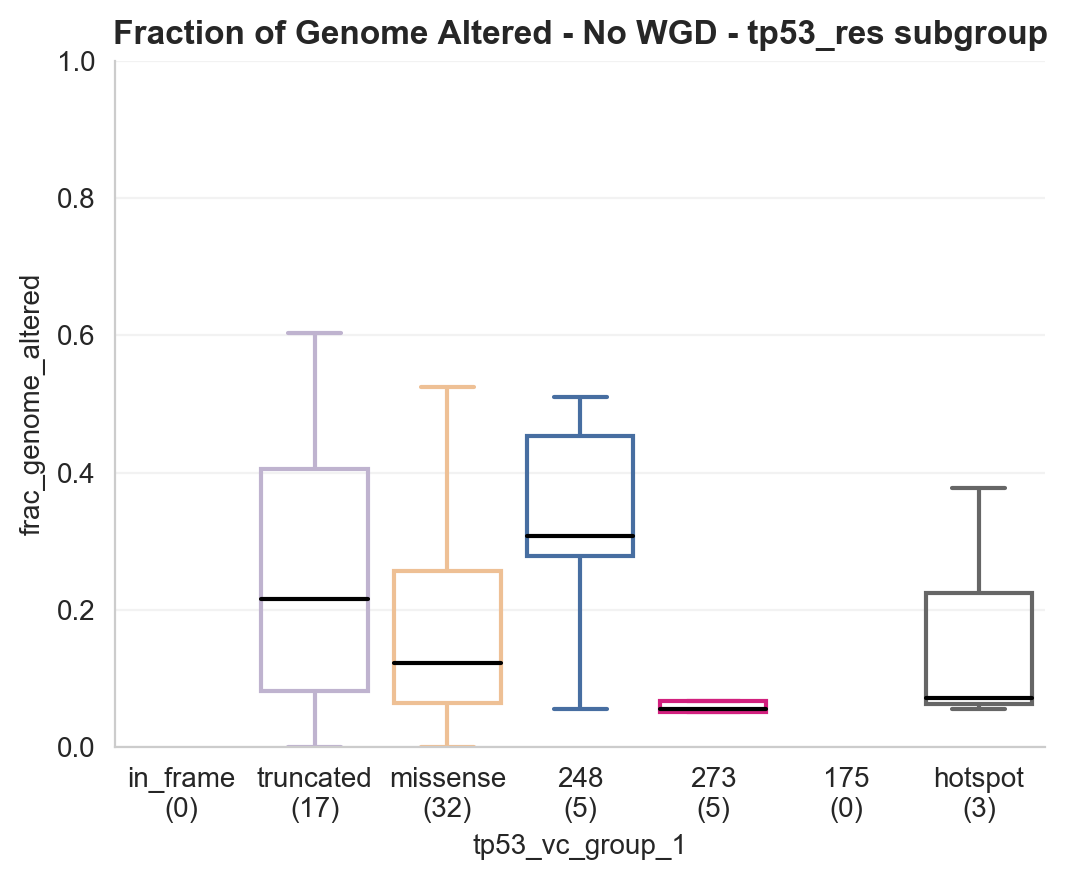

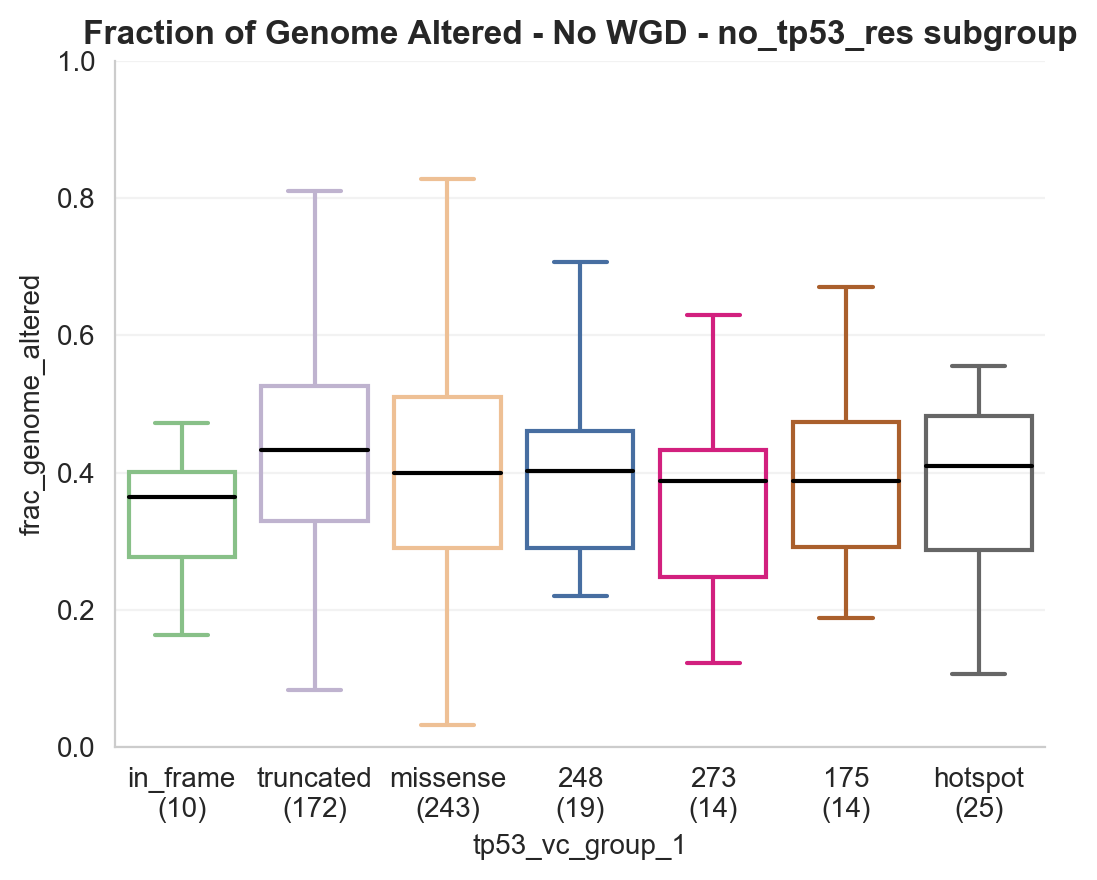

In [44]:
for group in ['tp53_res', 'no_tp53_res']:
    master_wt = master_hotspot[master_hotspot['tp53_res_group'] == group]

    fig, ax = boxplot_sampletype(df=master_wt,
                      group='tp53_vc_group_1',
                      palette=mutation_palette,
                      order=mutation_list,
                      metrics='frac_genome_altered',
                      figsize=(6,10),
                      title='Fraction of Genome Altered - No WGD - {} subgroup'.format(group),
                      xlim=[0,1])
    plt.show()

## SNV / INDEL Analysis
In this section we compare SNV and INDEL mutations. As in the previous section, we cut the cohort to keep only samples with exactly 1 tp53 mutation.

###  # of Drivers / SNV Drivers / INDEL Drivers 

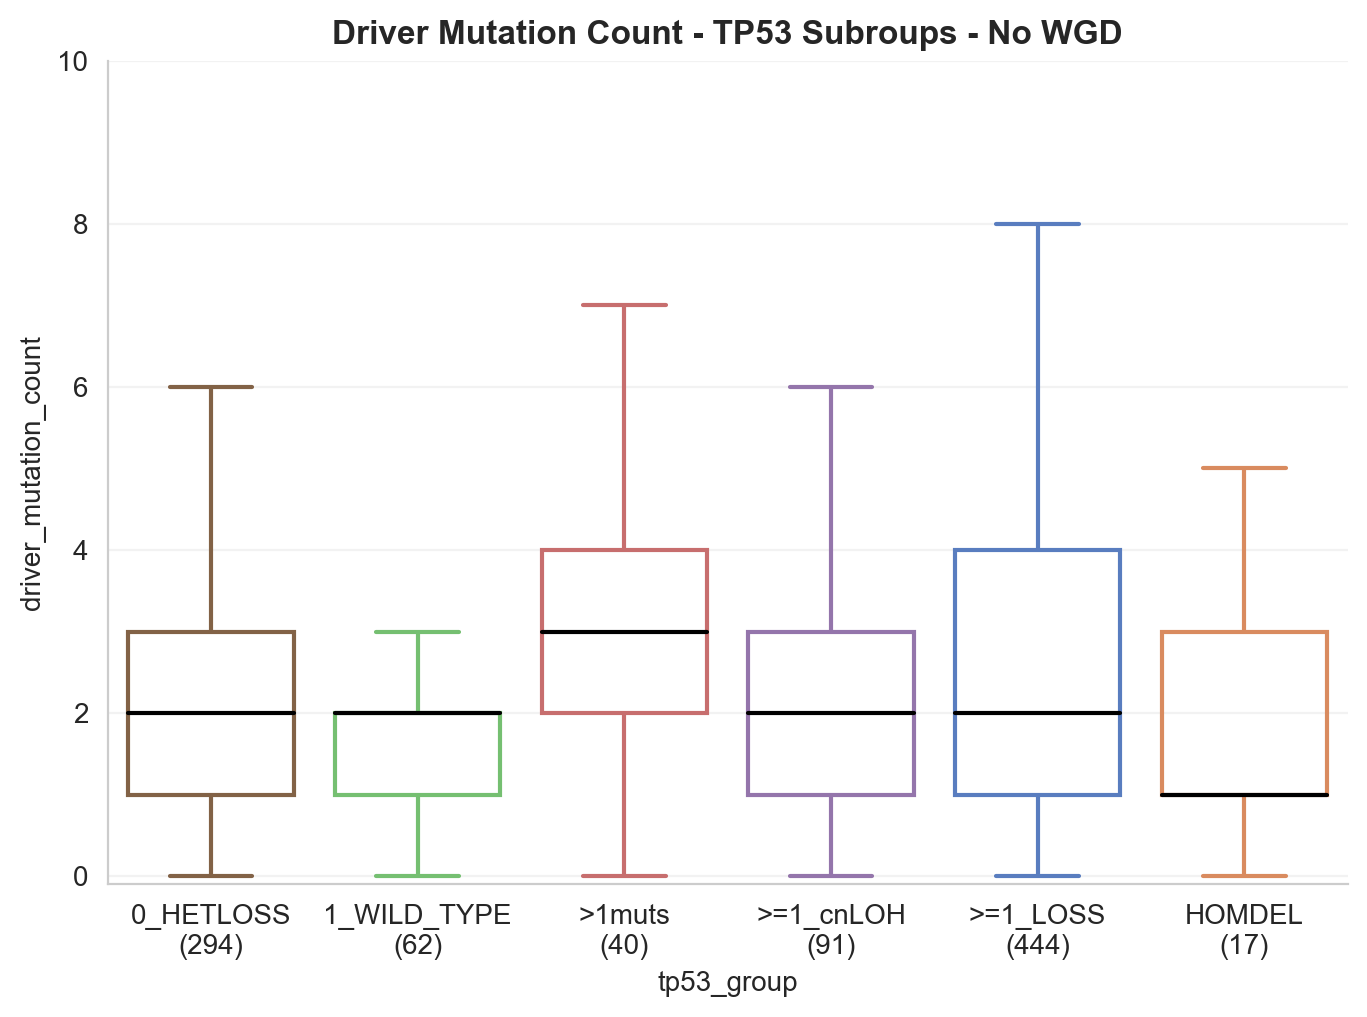

,0,1,2
0,,size,driver_mutation_count
1,1_WILD_TYPE,62,2
2,0_HETLOSS,294,2
3,,Statistics,p-value
4,,-1.489,0.136487
,0,1,2
0,,size,driver_mutation_count
1,1_WILD_TYPE,62,2
2,>=1_LOSS,444,2
3,,Statistics,p-value


In [14]:
fig, ax = boxplot_sampletype(df=master_no_wgd_cancer,
                  group='tp53_group',
                  palette=palette,
                  order=group_list,
                  metrics='driver_mutation_count',
                  figsize=(8,12),
                  title='Driver Mutation Count - TP53 Subroups - No WGD',
                  xlim=[-0.1,10])
plt.show()

display_side_by_side(get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='driver_mutation_count', 
               group_list=['1_WILD_TYPE', '0_HETLOSS']),
       
       get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='driver_mutation_count', 
               group_list=['1_WILD_TYPE', '>=1_LOSS']),
        
       get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='driver_mutation_count', 
               group_list=['>1muts', '>=1_LOSS']))

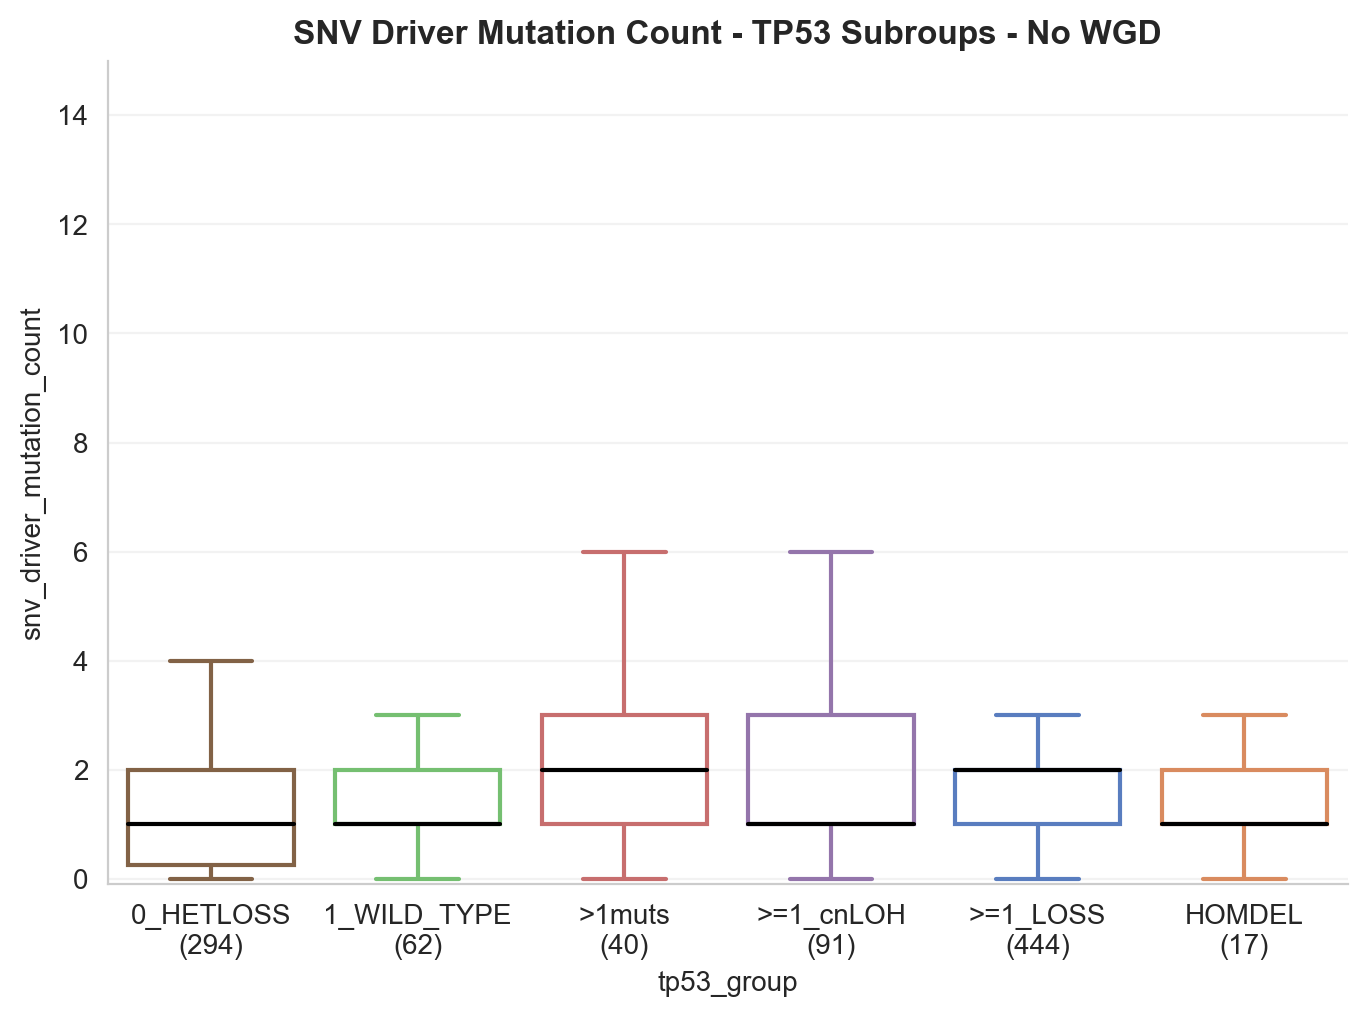

,0,1,2
0,,size,snv_driver_mutation_count
1,1_WILD_TYPE,62,1
2,0_HETLOSS,294,1
3,,Statistics,p-value
4,,-0.769284,0.441725
,0,1,2
0,,size,snv_driver_mutation_count
1,1_WILD_TYPE,62,1
2,>=1_LOSS,444,2
3,,Statistics,p-value


In [15]:
fig, ax = boxplot_sampletype(df=master_no_wgd_cancer,
                  group='tp53_group',
                  palette=palette,
                  order=group_list,
                  metrics='snv_driver_mutation_count',
                  figsize=(8,12),
                  title='SNV Driver Mutation Count - TP53 Subroups - No WGD',
                  xlim=[-0.1,15])
plt.show()

display_side_by_side(get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='snv_driver_mutation_count', 
               group_list=['1_WILD_TYPE', '0_HETLOSS']),
       
       get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='snv_driver_mutation_count', 
               group_list=['1_WILD_TYPE', '>=1_LOSS']),
        
       get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='snv_driver_mutation_count', 
               group_list=['>1muts', '>=1_LOSS']))

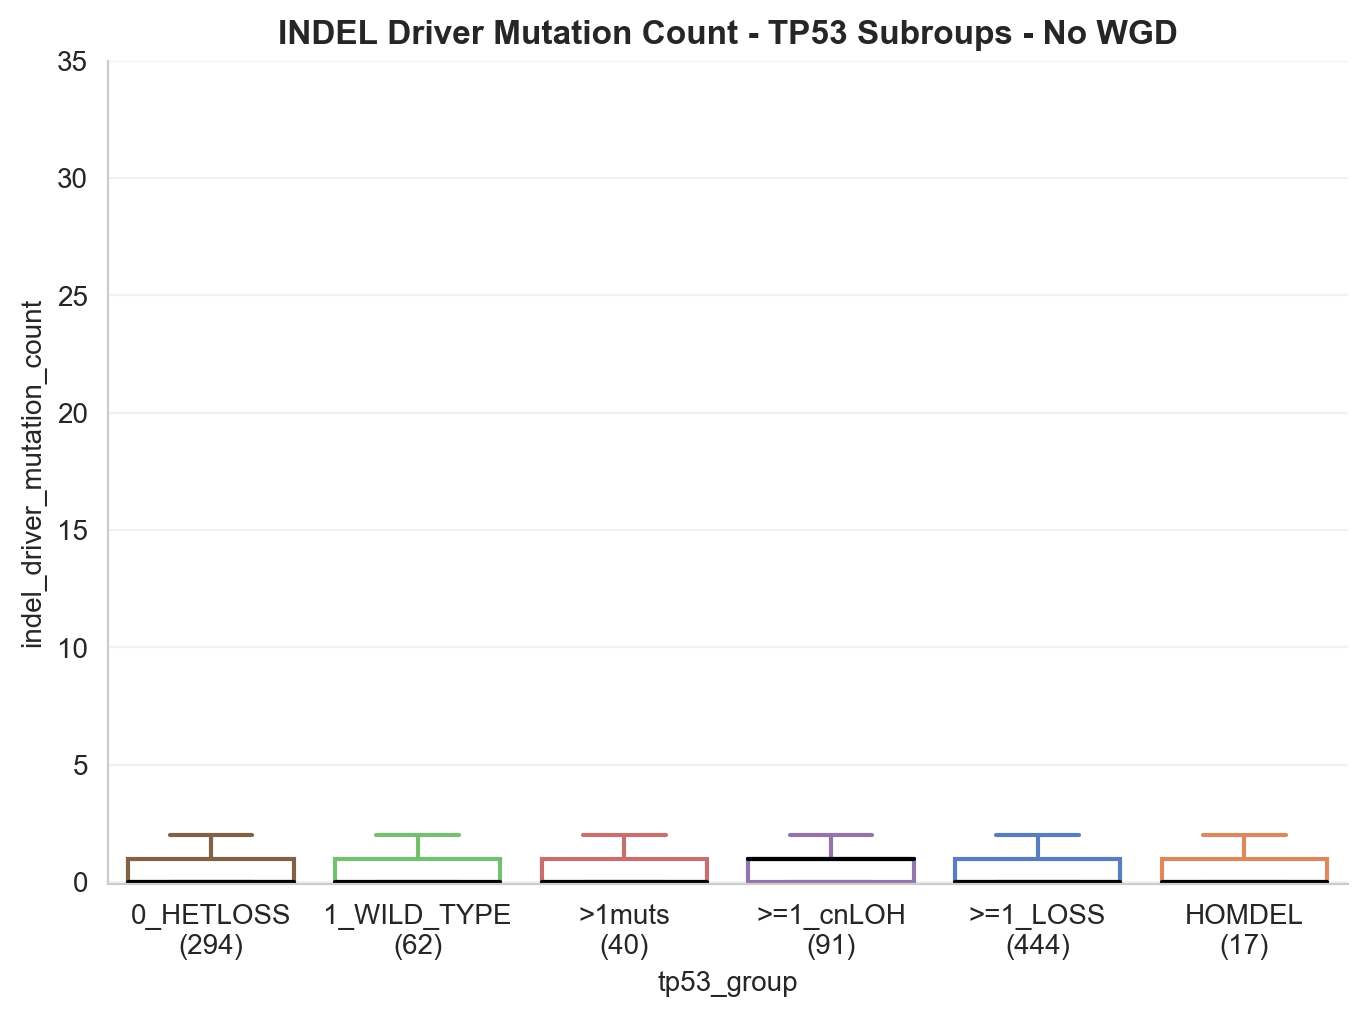

,0,1,2
0,,size,indel_driver_mutation_count
1,1_WILD_TYPE,62,0
2,0_HETLOSS,294,0
3,,Statistics,p-value
4,,-1.73887,0.082058
,0,1,2
0,,size,indel_driver_mutation_count
1,1_WILD_TYPE,62,0
2,>=1_LOSS,444,0
3,,Statistics,p-value


In [16]:
fig, ax = boxplot_sampletype(df=master_no_wgd_cancer,
                  group='tp53_group',
                  palette=palette,
                  order=group_list,
                  metrics='indel_driver_mutation_count',
                  figsize=(8,12),
                  title='INDEL Driver Mutation Count - TP53 Subroups - No WGD',
                  xlim=[-0.1,35])
plt.show()

display_side_by_side(get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='indel_driver_mutation_count', 
               group_list=['1_WILD_TYPE', '0_HETLOSS']),
       
       get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='indel_driver_mutation_count', 
               group_list=['1_WILD_TYPE', '>=1_LOSS']),
        
       get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='indel_driver_mutation_count', 
               group_list=['>1muts', '>=1_LOSS']))

Here, one major information:
* In NSCLC, there are very few numbers of Co-Drivers, INDEL Co-Drivers nor SNV Co-Drivers.
    * Maybe TP53 mutations in NSCLC are very pervasvie and do not need more drivers to expand

### Genome Instability 
The idea here is to see if we have differences in Fraction of Genome Altered if we cut our Cancer cohort on the number of drivers per sample. 

Do we have more instability with more INDEL Driver Mutations within the same subgroup?

#### 1_WILD_TYPE Subgroup

In [19]:
master_no_wgd_cancer_wt = master_no_wgd_cancer[master_no_wgd_cancer['tp53_group'] == '1_WILD_TYPE']

thr=1

def get_driver_groups(x):
    if x.indel_driver_mutation_count > thr:
        return 'High Co-Driver Count'
    if x.indel_driver_mutation_count <= thr:
        return 'Low Co-Driver Count'
    

master_no_wgd_cancer_wt['co_driver_group'] = master_no_wgd_cancer_wt.apply(get_driver_groups, axis=1)

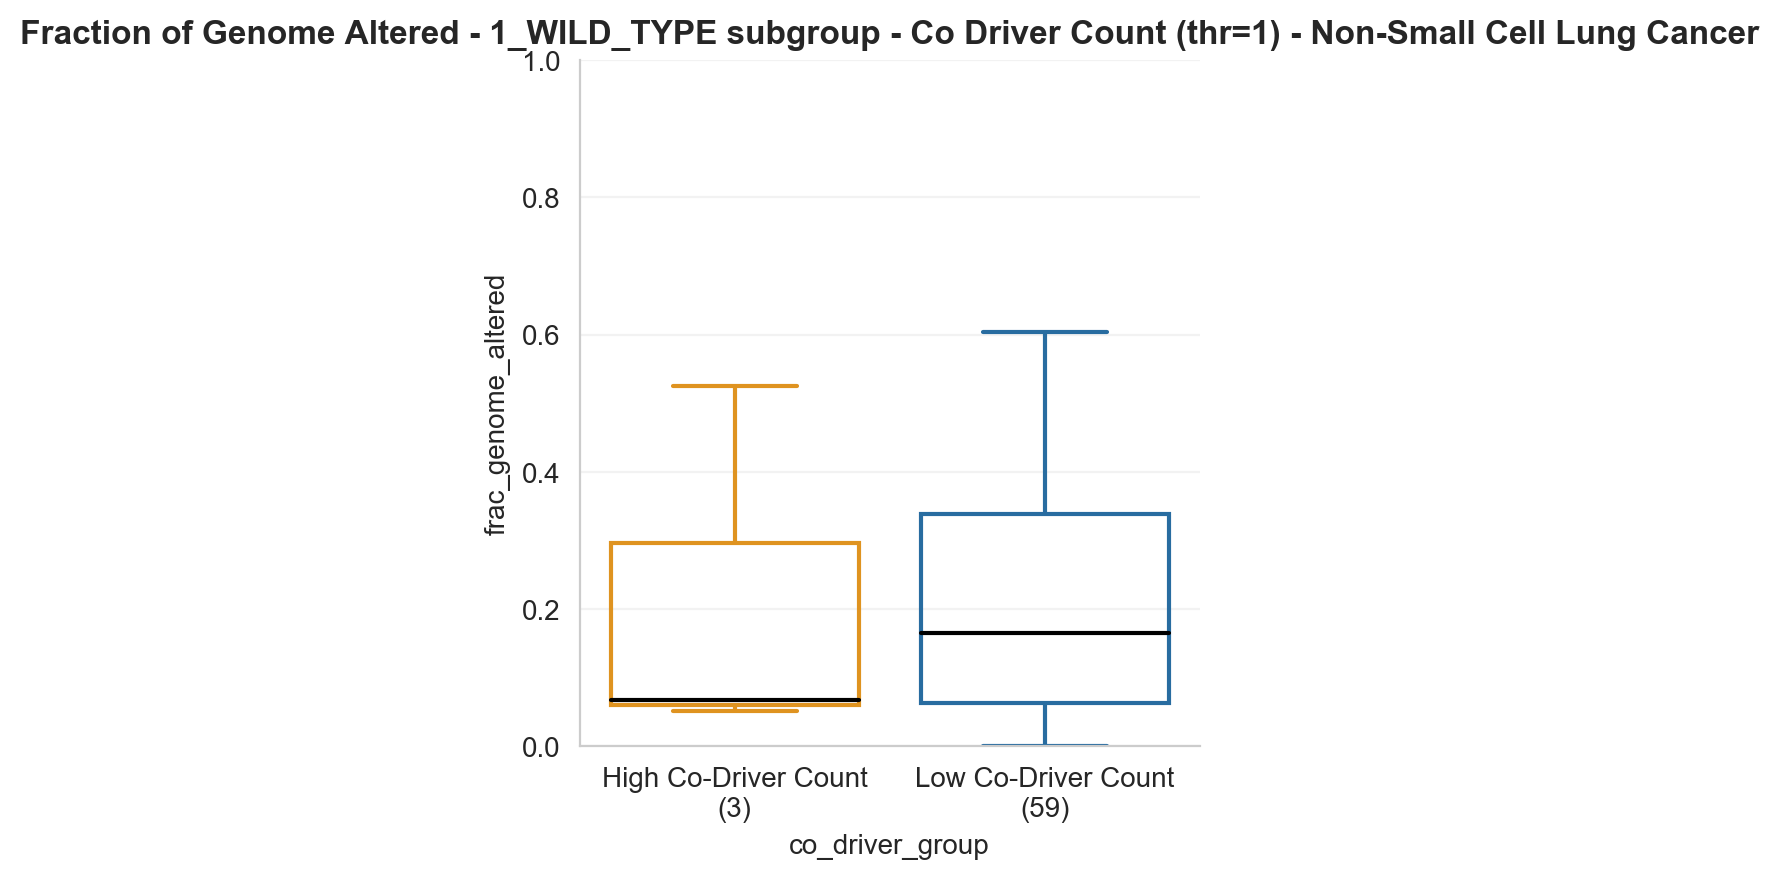

,0,1,2
0,,size,frac_genome_altered
1,High Co-Driver Count,3,0.068
2,Low Co-Driver Count,59,0.165
3,,Statistics,p-value
4,,-0.213229,0.831148


In [20]:
fig, ax = boxplot_sampletype(df=master_no_wgd_cancer_wt,
                  group='co_driver_group',
                  palette={'High Co-Driver Count': '#FF9900' , 'Low Co-Driver Count': '#146EB4'},
                  order=['High Co-Driver Count', 'Low Co-Driver Count'],
                  metrics='frac_genome_altered',
                  figsize=(4,10),
                  title='Fraction of Genome Altered - 1_WILD_TYPE subgroup - Co Driver Count (thr={}) - {}'.format(thr,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_no_wgd_cancer_wt,
               group='co_driver_group',
               metrics='frac_genome_altered',
               group_list=['High Co-Driver Count', 'Low Co-Driver Count'])

#### 0_HETLOSS

In [21]:
master_no_wgd_cancer_het = master_no_wgd_cancer[master_no_wgd_cancer['tp53_group'] == '0_HETLOSS']

thr=1

def get_driver_groups(x):
    if x.indel_driver_mutation_count > thr:
        return 'High Co-Driver Count'
    if x.indel_driver_mutation_count <= thr:
        return 'Low Co-Driver Count'
    

master_no_wgd_cancer_het['co_driver_group'] = master_no_wgd_cancer_het.apply(get_driver_groups, axis=1)

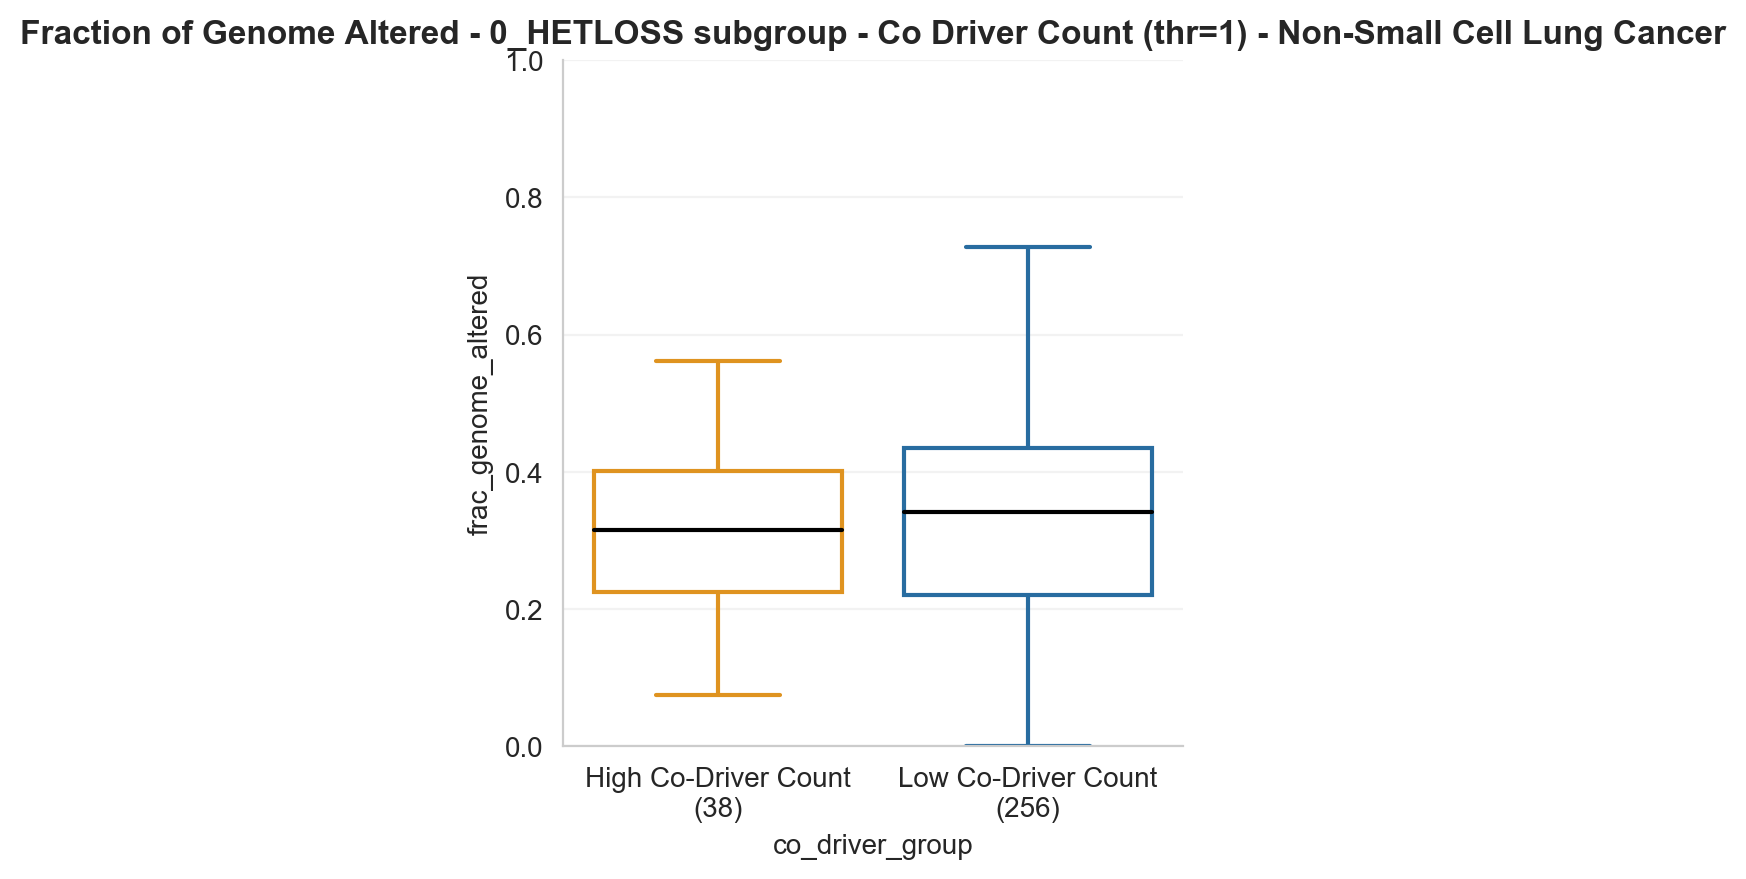

,0,1,2
0,,size,frac_genome_altered
1,High Co-Driver Count,38,0.315
2,Low Co-Driver Count,256,0.342
3,,Statistics,p-value
4,,-0.522467,0.601345


In [22]:
fig, ax = boxplot_sampletype(df=master_no_wgd_cancer_het,
                  group='co_driver_group',
                  palette={'High Co-Driver Count': '#FF9900' , 'Low Co-Driver Count': '#146EB4'},
                  order=['High Co-Driver Count', 'Low Co-Driver Count'],
                  metrics='frac_genome_altered',
                  figsize=(4,10),
                  title='Fraction of Genome Altered - 0_HETLOSS subgroup - Co Driver Count (thr={}) - {}'.format(thr,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_no_wgd_cancer_het,
               group='co_driver_group',
               metrics='frac_genome_altered',
               group_list=['High Co-Driver Count', 'Low Co-Driver Count'])

## Co Driver Analysis

In [29]:
codrivers_cancer = get_major_codrivers(master=master_no_wgd_cancer,
                    maf=maf_cohort_nowgd,
                    head=15)

codrivers_cancer_tp53 = get_major_codrivers(master=master_no_wgd_cancer[master_no_wgd_cancer['tp53_count'] >= 1],
                    maf=maf_cohort_nowgd,
                    head=15)

In [30]:
co_drivers = pd.merge(codrivers_cancer, codrivers_cancer_tp53, on='Hugo_Symbol')
co_drivers.columns = ['cancer', 'cancer_tp53']

In [31]:
co_drivers['ratio'] = co_drivers.apply(lambda x: 100*round(x.cancer_tp53/x.cancer, 4) , axis=1)
co_drivers = co_drivers.sort_values(by='ratio', ascending=False)

In [32]:
co_drivers

,cancer,cancer_tp53,ratio
Hugo_Symbol,,,
RB1,59,45,76.27
CDKN2A,112,81,72.32
PIK3CA,116,53,45.69
BRAF,81,35,43.21
NF1,91,36,39.56
ARID1A,78,30,38.46
EGFR,452,146,32.30
SETD2,89,25,28.09
KEAP1,129,36,27.91


In [34]:
codrivers_cancer

,count
Hugo_Symbol,
KRAS,594
EGFR,452
STK11,262
RBM10,155
KEAP1,129
PIK3CA,116
CDKN2A,112
NF1,91
SETD2,89


Text(0.5, 1.0, 'Drivers Frequency in Non-Small Cell Lung Cancer')

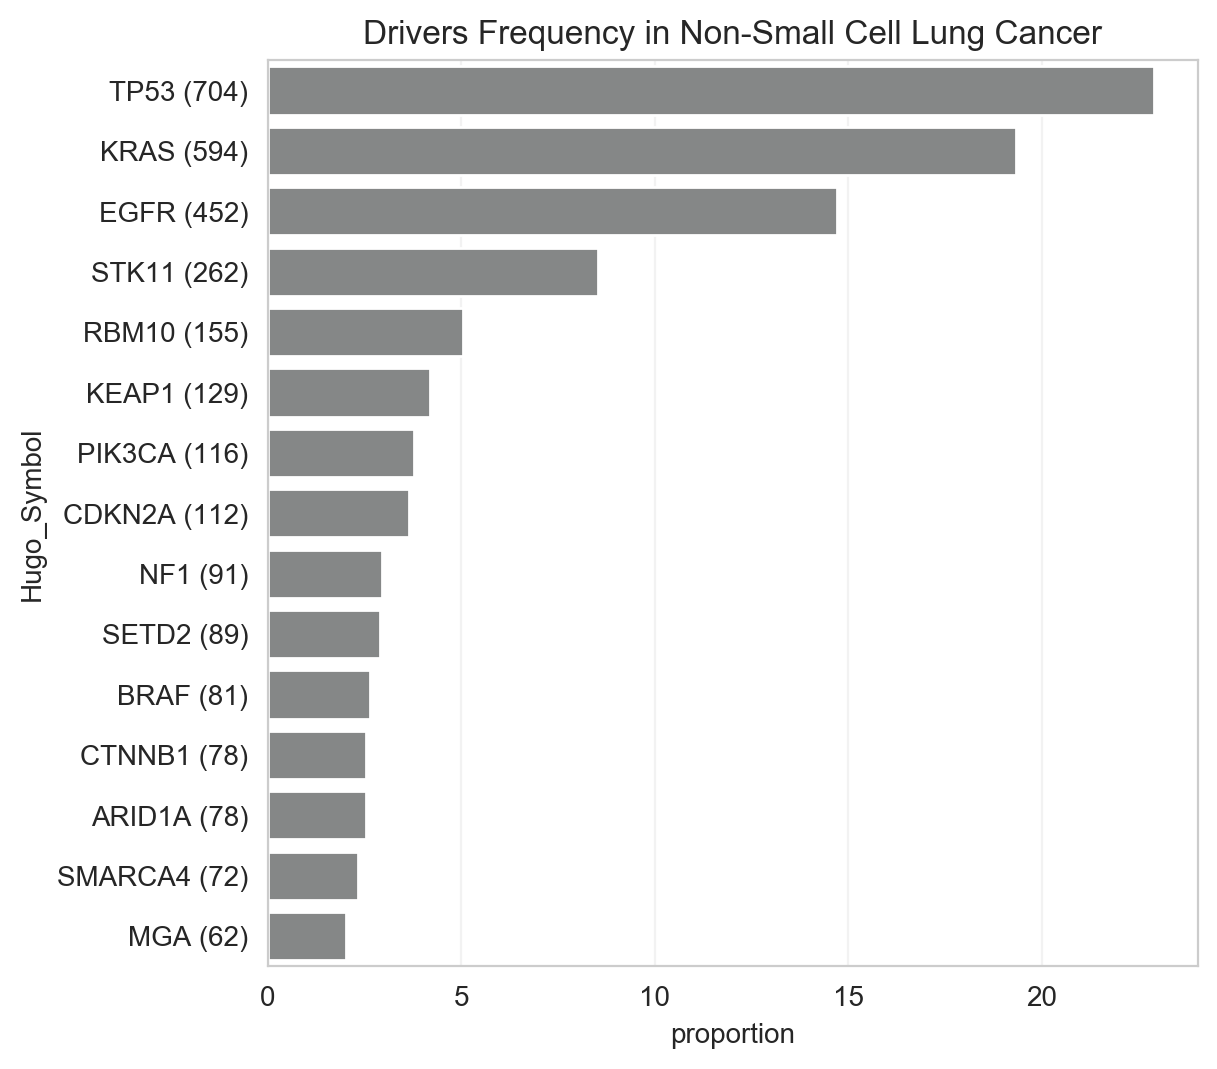

In [74]:
labels = []
codrivers_cancer = get_major_codrivers(master=master_no_wgd_cancer,
                                       maf=maf_cohort_nowgd,
                                       head=15,
                                       tp53=True)

codrivers_cancer['proportion'] = codrivers_cancer.apply(lambda x: 100* round(x['count'] / codrivers_cancer.sum().values[0], 4), axis=1)

for element in codrivers_cancer.head(15).index.tolist():
    labels.append(element + ' ('+ str(int(codrivers_cancer.loc[element]['count']))+')')

ax = sns.barplot(y=codrivers_cancer.head(15).index, x='proportion',data=codrivers_cancer.head(15)[['proportion']], color='#7F8C8D', saturation=.2)
ax.set_yticklabels(labels)
ax.set_title('Drivers Frequency in {}'.format(cancer))

Text(0.5, 1.0, 'Co-Drivers Enrichment in TP53 State')

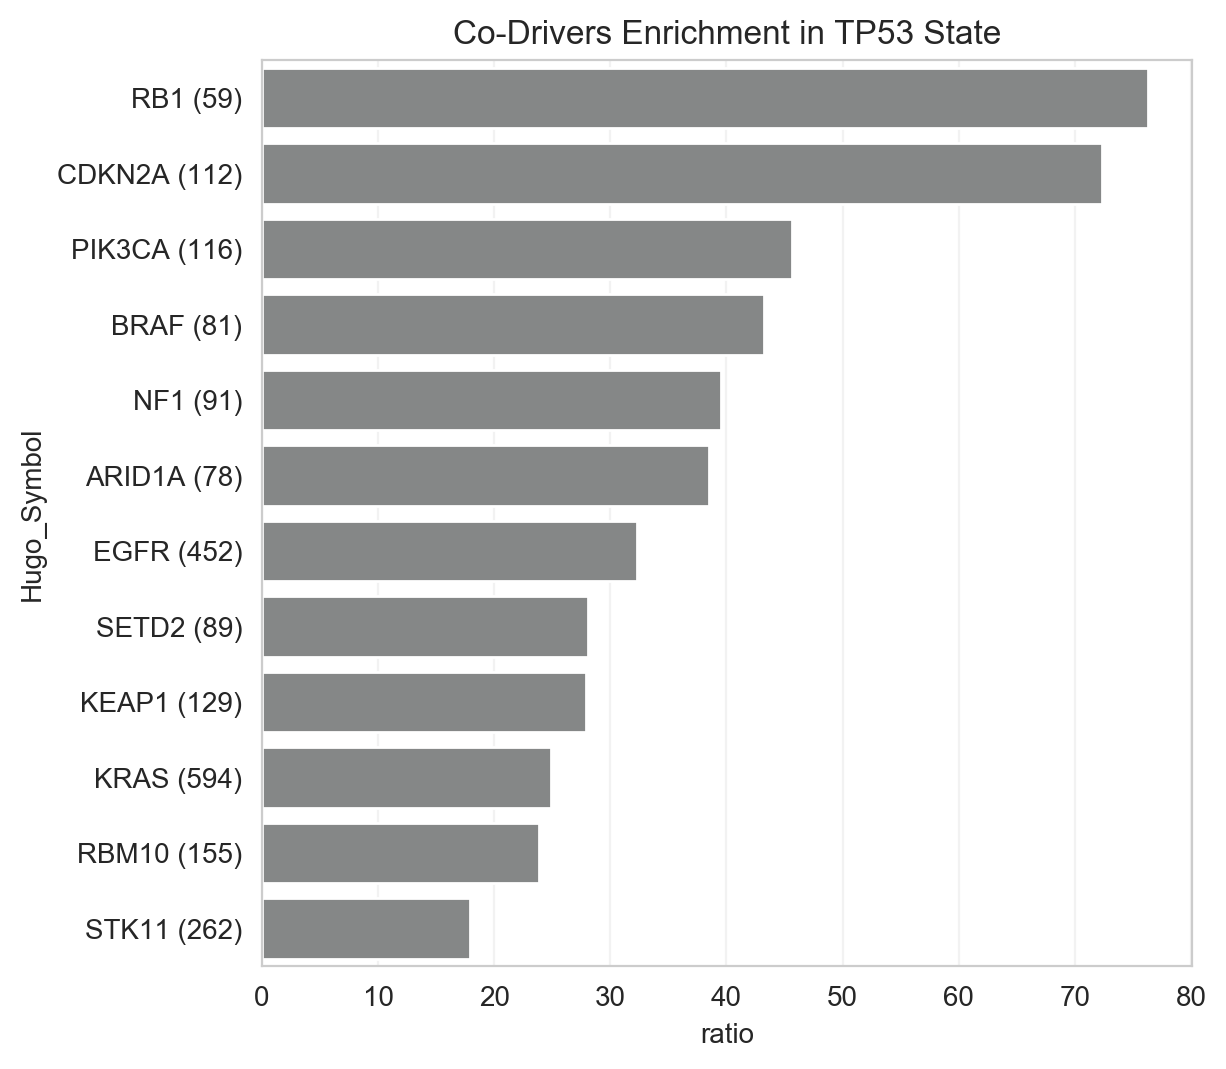

In [33]:
labels = []
for element in co_drivers.index.tolist():
    labels.append(element + ' ('+ str(int(co_drivers.loc[element]['cancer']))+')')

ax = sns.barplot(y=co_drivers.index, x='ratio',data=co_drivers[['ratio']], color='#7F8C8D', saturation=.2)
ax.set_yticklabels(labels)
ax.set_title('Co-Drivers Enrichment in TP53 State')

### Co-Drivers per subgroup

In [87]:
co_drivers_res = create_co_drivers_table(master=master_no_wgd_cancer, 
                                                group_type='tp53_res_group',
                                                group_1='tp53_res',
                                                group_2='no_tp53_res')
co_drivers_res

,count_x,proportion_1,count_y,proportion_2
Hugo_Symbol,,,,
EGFR,128,-16.54,114,8.89
KRAS,115,-14.86,120,9.35
STK11,44,-5.68,41,3.20
CTNNB1,24,-3.10,9,0.70
RBM10,24,-3.10,32,2.49
NF1,21,-2.71,30,2.34
PIK3CA,20,-2.58,46,3.59
SMAD4,16,-2.07,18,1.40
ARID1A,16,-2.07,28,2.18


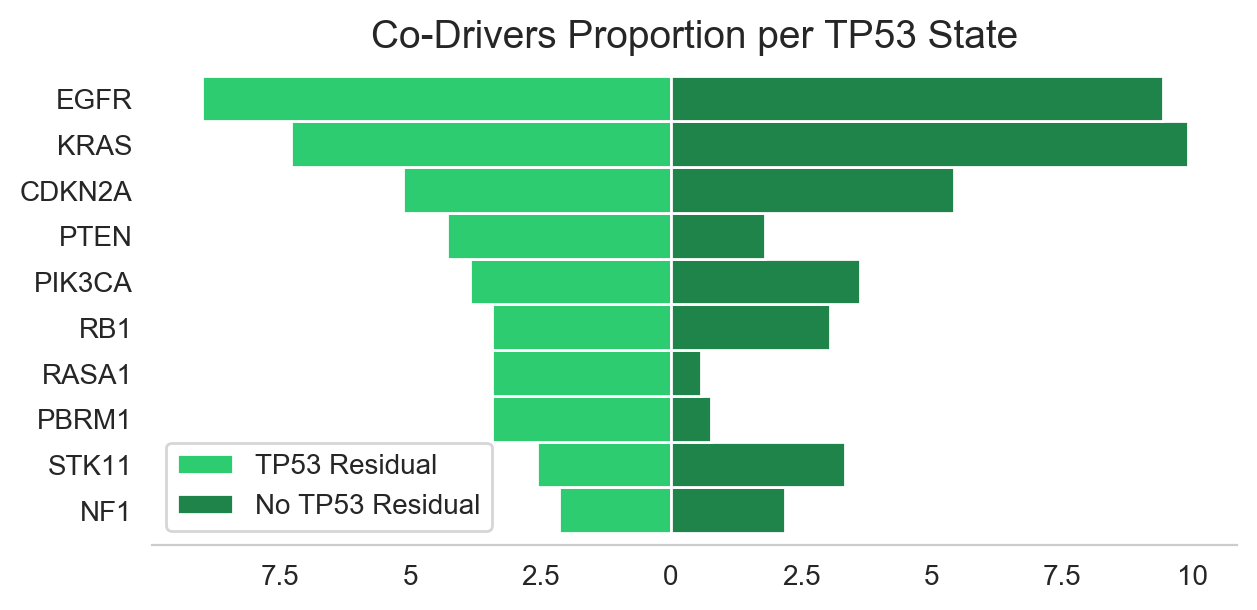

In [89]:
fig=plt.figure(figsize=(7,7))
ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

co_drivers_cnloh_loss[['proportion_1', 'proportion_2']].head(10)[::-1].plot.barh(stacked=True, ax=ax, width=1, color = ['#2ECC71','#1E8449'])
ax.legend(['TP53 Residual', 'No TP53 Residual'], fontsize=10)
ax.set_title('Co-Drivers Proportion per TP53 State', fontsize=14)

plt.yticks(fontsize=10)
ax.set_ylabel('')
a=ax.get_xticks().tolist()
a = [10, 7.5, 5, 2.5, 0, 2.5, 5, 7.5, 10, 12.5]
ax.set_xticklabels(a, fontsize=10)
plt.grid(b=None)

plt.show()

In [36]:
co_drivers_cnloh_loss = create_co_drivers_table(master=master_no_wgd_cancer, 
                                                group_type='tp53_group',
                                                group_1='>=1_cnLOH',
                                                group_2='>=1_LOSS')
co_drivers_cnloh_loss

,count_x,proportion_1,count_y,proportion_2
Hugo_Symbol,,,,
EGFR,21,-9.01,99,9.45
KRAS,17,-7.30,104,9.92
CDKN2A,12,-5.15,57,5.44
PTEN,10,-4.29,19,1.81
PIK3CA,9,-3.86,38,3.63
RB1,8,-3.43,32,3.05
RASA1,8,-3.43,6,0.57
PBRM1,8,-3.43,8,0.76
STK11,6,-2.58,35,3.34


NameError: name 'subgroup' is not defined

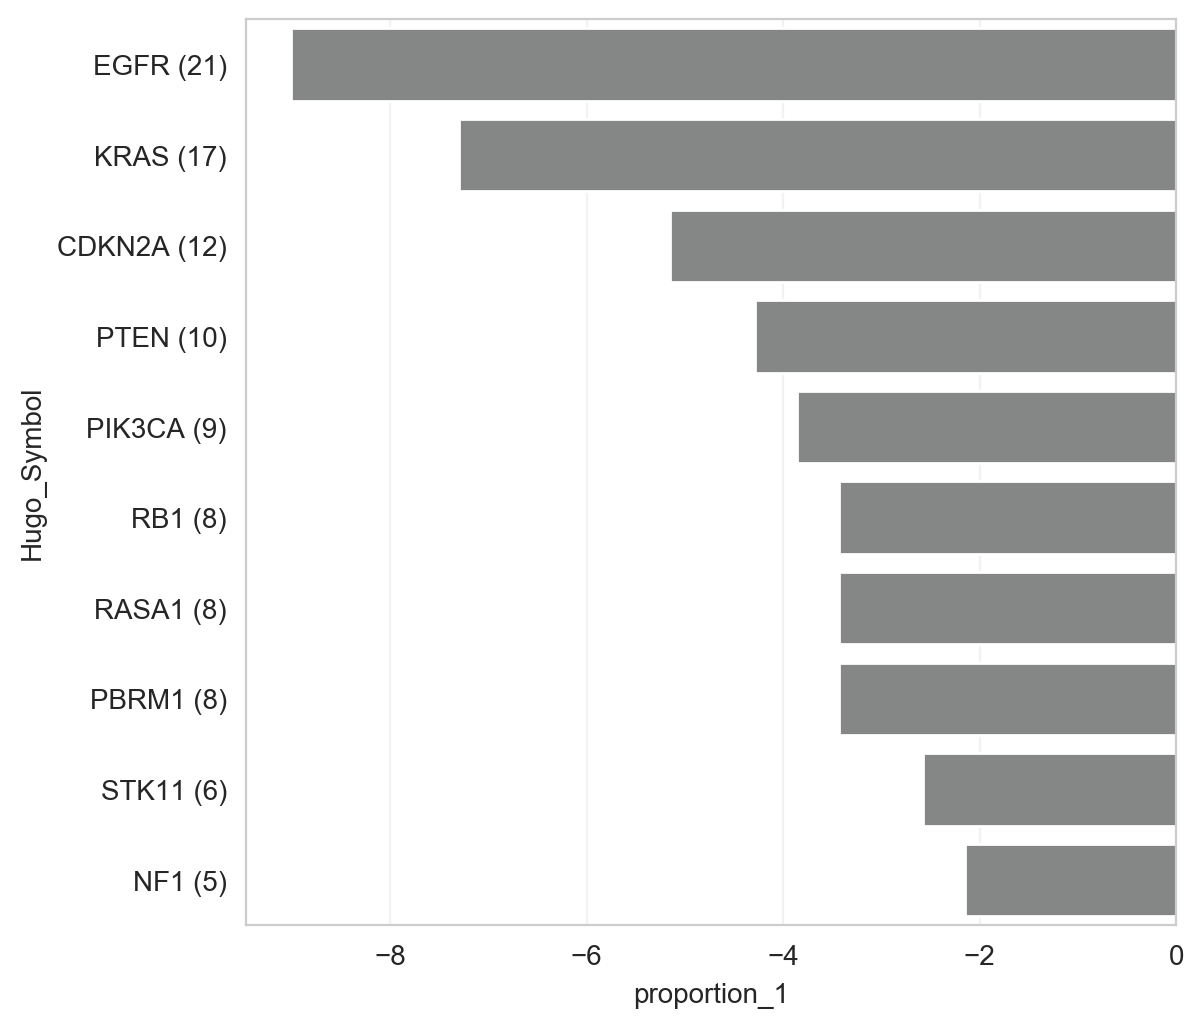

In [37]:
labels = []
for element in co_drivers_cnloh_loss.head(10).index.tolist():
    labels.append(element + ' ('+ str(int(co_drivers_cnloh_loss.loc[element]['count_x']))+')')

ax = sns.barplot(y=co_drivers_cnloh_loss.head(10).index, x='proportion_1',data=co_drivers_cnloh_loss.head(10)[['proportion_1']], color='#7F8C8D', saturation=.2)
ax.set_yticklabels(labels)
ax.set_title('Co-Drivers Frequency in {} - {}'.format(subgroup, cancer))

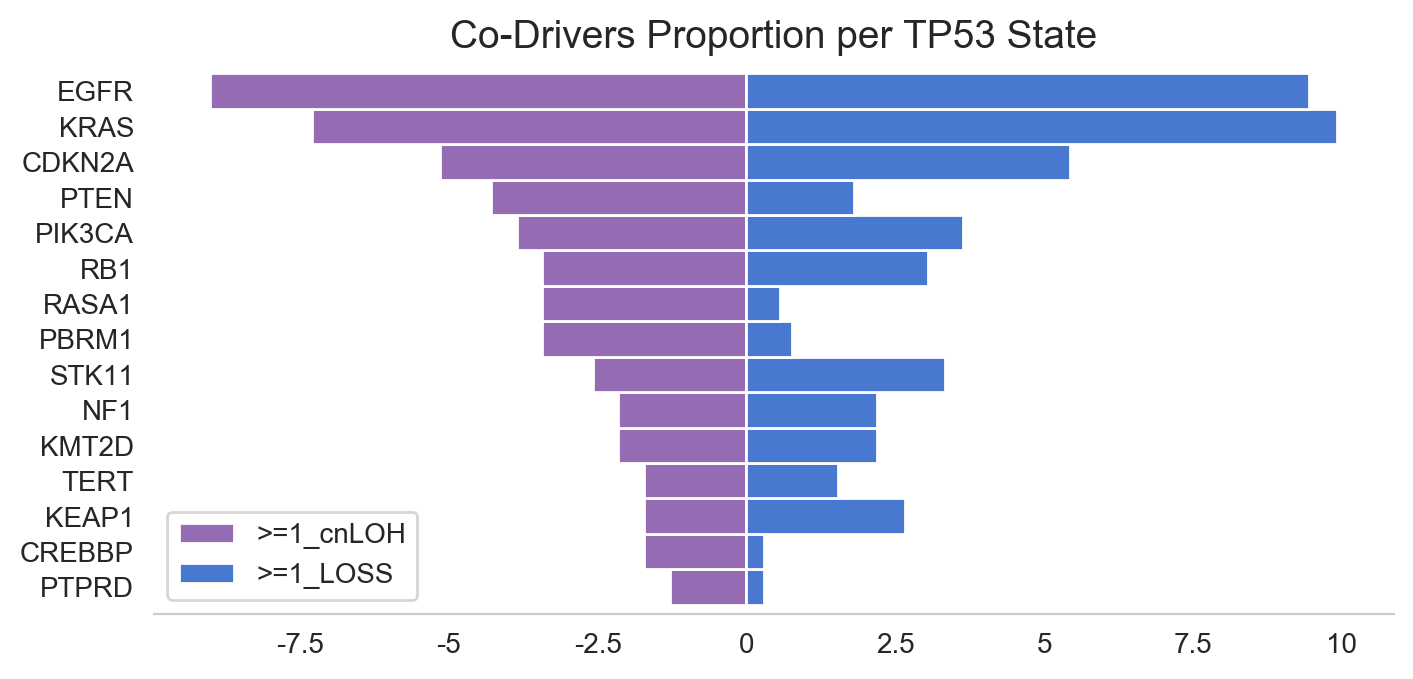

In [41]:
fig=plt.figure(figsize=(8,8))
ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

co_drivers_cnloh_loss[['proportion_1', 'proportion_2']].head(15)[::-1].plot.barh(stacked=True, ax=ax, width=1, color = [mc[4],mc[0]])
ax.legend(['>=1_cnLOH', '>=1_LOSS'], fontsize=10)
ax.set_title('Co-Drivers Proportion per TP53 State', fontsize=14)

plt.yticks(fontsize=10)
ax.set_ylabel('')
a=ax.get_xticks().tolist()
a = [-10, -7.5, -5, -2.5, 0, 2.5, 5, 7.5, 10, 12.5]
ax.set_xticklabels(a, fontsize=10)
plt.grid(b=None)

plt.show()

* The big picture is the same for both cancers
* Enrichment in PTEN and RASA1 / PBRM1 for >=1_cnLOH
---

In [47]:
co_drivers_losses = create_co_drivers_table(master=master_no_wgd_cancer, 
                                                group_type='tp53_group',
                                                group_1='0_HETLOSS',
                                                group_2='>=1_LOSS')
co_drivers_losses

,count_x,proportion_1,count_y,proportion_2
Hugo_Symbol,,,,
EGFR,108,-17.01,99,9.45
KRAS,94,-14.80,104,9.92
STK11,39,-6.14,35,3.34
RBM10,23,-3.62,31,2.96
CTNNB1,23,-3.62,7,0.67
NF1,17,-2.68,23,2.19
PIK3CA,16,-2.52,38,3.63
MGA,13,-2.05,17,1.62
SMAD4,13,-2.05,15,1.43


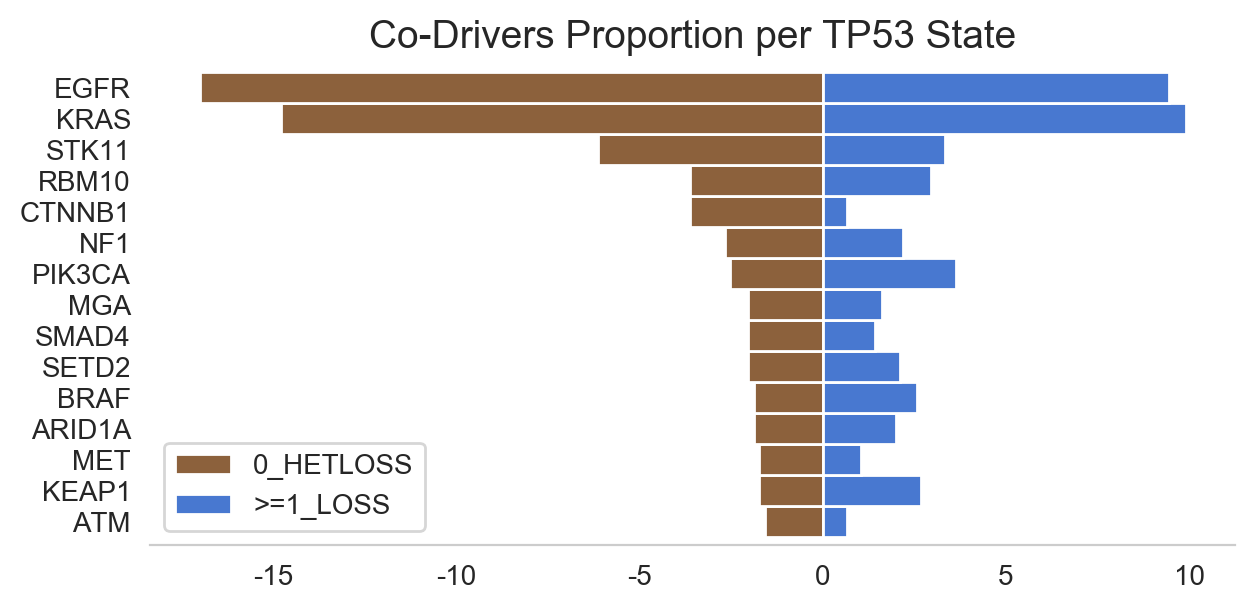

In [51]:
fig=plt.figure(figsize=(7,7))
ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

co_drivers_losses[['proportion_1', 'proportion_2']].head(15)[::-1].plot.barh(stacked=True, ax=ax, width=1, color = [mc[5],mc[0]])
ax.legend(['0_HETLOSS', '>=1_LOSS'], fontsize=10)
ax.set_title('Co-Drivers Proportion per TP53 State', fontsize=14)

plt.yticks(fontsize=10)
ax.set_ylabel('')
a=ax.get_xticks().tolist()
a = [-20, -15, -10, -5, 0, 5, 10, 15]
ax.set_xticklabels(a, fontsize=10)
plt.grid(b=None)

plt.show()

* Enrichment in **EGFR**, **KRAS**, **STK11** for 0_HETLOSS

---

In [48]:
co_drivers_mult_cnloh = create_co_drivers_table(master=master_no_wgd_cancer, 
                                                group_type='tp53_group',
                                                group_1='>1muts',
                                                group_2='>=1_cnLOH')
co_drivers_mult_cnloh

,count_x,proportion_1,count_y,proportion_2
Hugo_Symbol,,,,
EGFR,6,-5.17,21,9.01
KRAS,6,-5.17,17,7.30
CDKN2A,6,-5.17,12,5.15
KMT2D,5,-4.31,5,2.15
APC,5,-4.31,2,0.86
NF1,5,-4.31,5,2.15
ARID1A,3,-2.59,3,1.29
KMT2C,3,-2.59,1,0.43
RB1,3,-2.59,8,3.43


In [52]:
get_major_codrivers(master=master_no_wgd_cancer[master_no_wgd_cancer['tp53_group'] == '>1muts'],
                    maf=maf_cohort_nowgd,
                    head=100)

,count
Hugo_Symbol,
EGFR,6
KRAS,6
CDKN2A,6
KMT2D,5
APC,5
NF1,5
ARID1A,3
KMT2C,3
RB1,3


[-6.0, -4.0, -2.0, 0.0, 2.0, 4.0, 6.0, 8.0, 10.0]


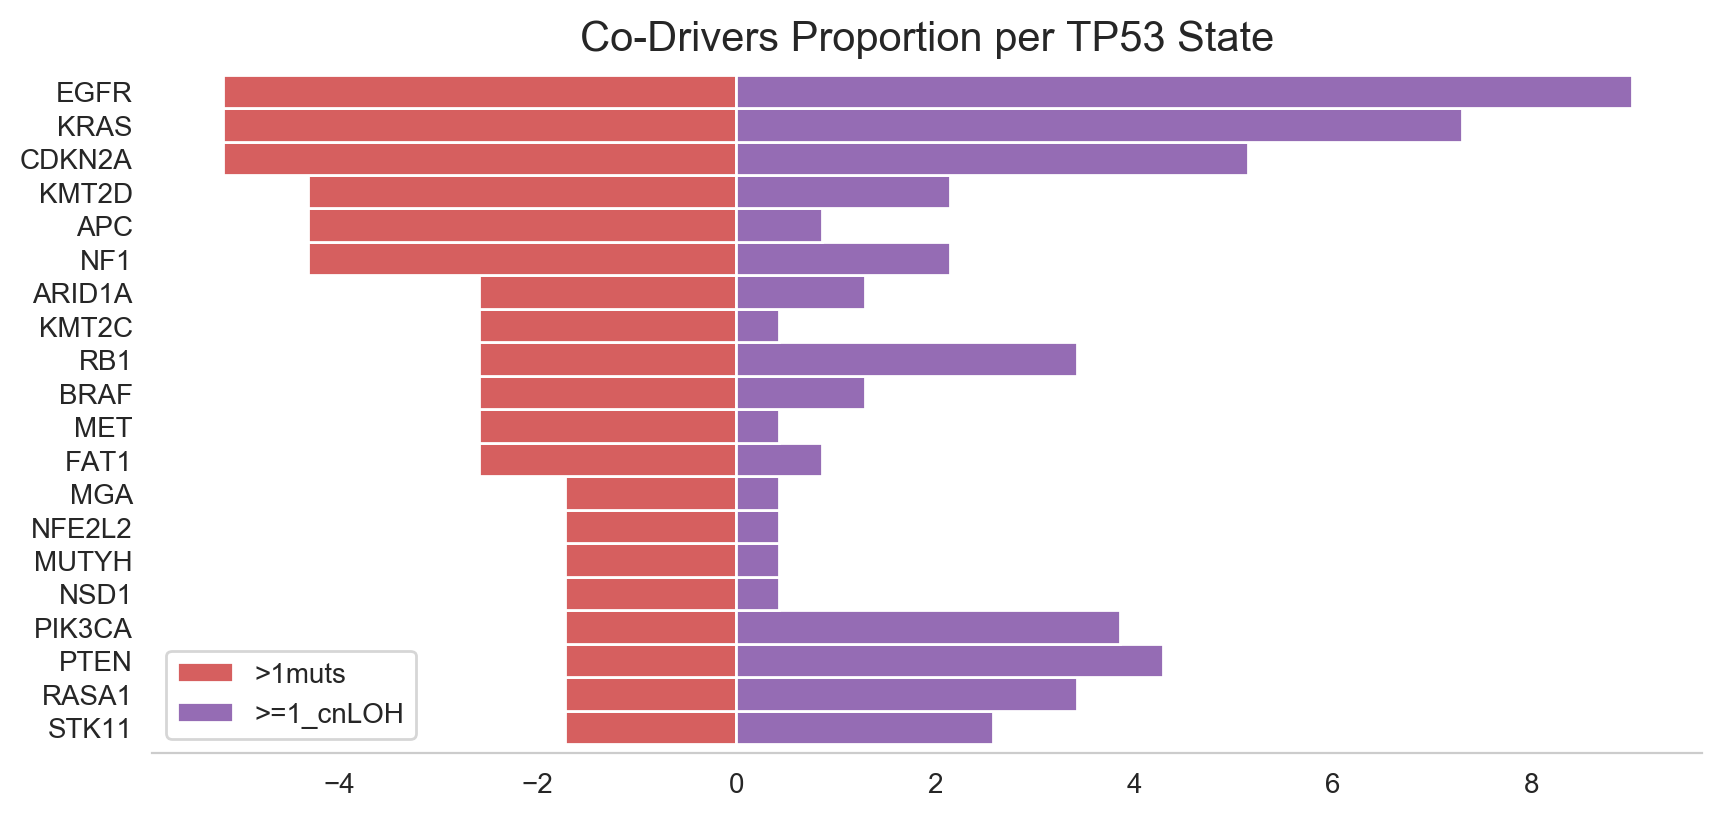

In [53]:
fig=plt.figure(figsize=(10,10))
ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

co_drivers_mult_cnloh[['proportion_1', 'proportion_2']].head(20)[::-1].plot.barh(stacked=True, ax=ax, width=1, color = [mc[3],mc[4]])
ax.legend(['>1muts', '>=1_cnLOH'], fontsize=10)
ax.set_title('Co-Drivers Proportion per TP53 State', fontsize=15)

plt.yticks(fontsize=10)
ax.set_ylabel('')
a=ax.get_xticks().tolist()
print(a)
#a = [-20, -10, 0, 10, 20, 30, 40]
#ax.set_xticklabels(a, fontsize=10)
plt.grid(b=None)

plt.show()

* Hard to interpret as we have fewersamples in >1muts subgroup
---

In [57]:
co_drivers_wt_loss = create_co_drivers_table(master=master_no_wgd_cancer, 
                                                group_type='tp53_group',
                                                group_1='1_WILD_TYPE',
                                                group_2='0_HETLOSS')
co_drivers_wt_loss

,count_x,proportion_1,count_y,proportion_2
Hugo_Symbol,,,,
KRAS,17,-15.18,94,14.80
EGFR,15,-13.39,108,17.01
CDKN2A,5,-4.46,7,1.10
STK11,4,-3.57,39,6.14
NF1,3,-2.68,17,2.68
PIK3CA,3,-2.68,16,2.52
ARID1A,3,-2.68,12,1.89
SMAD4,3,-2.68,13,2.05
U2AF1,3,-2.68,3,0.47


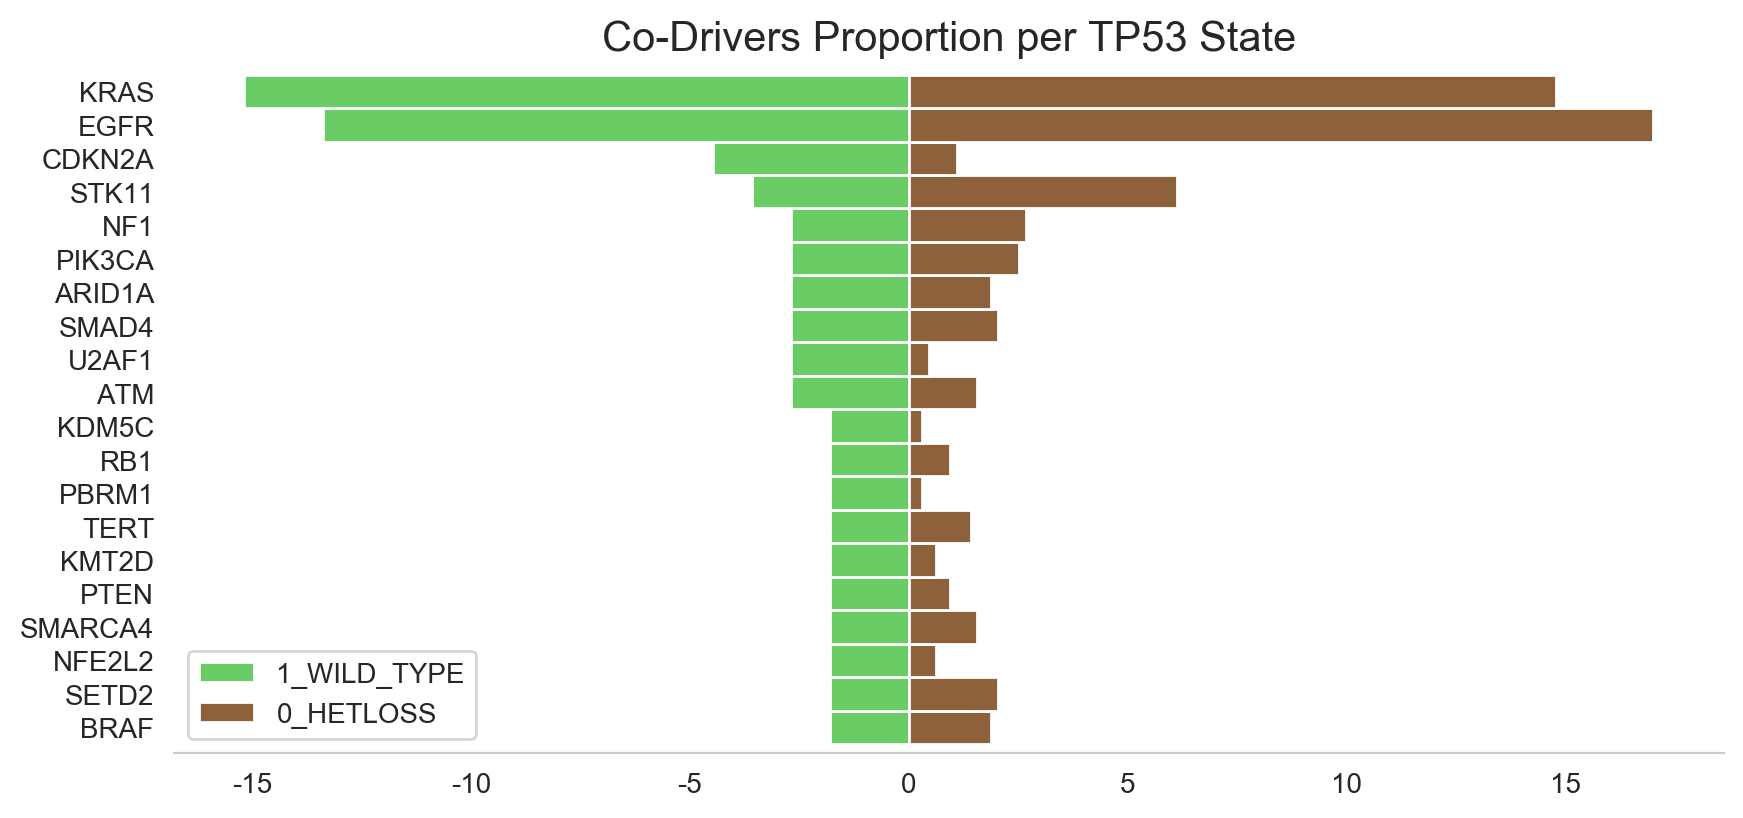

In [60]:
fig=plt.figure(figsize=(10,10))
ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

co_drivers_wt_loss[['proportion_1', 'proportion_2']].head(20)[::-1].plot.barh(stacked=True, ax=ax, width=1, color = [mc[2],mc[5]])
ax.legend(['1_WILD_TYPE', '0_HETLOSS'], fontsize=10)
ax.set_title('Co-Drivers Proportion per TP53 State', fontsize=15)

plt.yticks(fontsize=10)
ax.set_ylabel('')
a=ax.get_xticks().tolist()
a = [-20, -15, -10, -5, 0, 5, 10, 15, 20]
ax.set_xticklabels(a, fontsize=10)
plt.grid(b=None)

plt.show()

#### Comparison with WGD Cohort (WGD - TP53 - LOH)

In [61]:
def get_major_codrivers(master: pd.DataFrame, maf: pd.DataFrame, head:int = 10):
    samples = master.Tumor_Id.tolist()
    maf_filtered = maf[maf.Tumor_Sample_Barcode.isin(samples)][maf['driver'] == True][maf['Hugo_Symbol'] != 'TP53']
    h = pd.DataFrame(maf_filtered[['Hugo_Symbol']].groupby(['Hugo_Symbol']).size())
    h.columns = ['count']
    h = h.sort_values(by='count', ascending=False).head(head)
    
    return(h)

def create_co_drivers_table_wgd(master_1: pd.DataFrame, master_2: pd.DataFrame, group_type:str,  group_1: str):
    master_group_1 = master_1[master_1[group_type] == group_1]
    co_drivers_group_1 = get_major_codrivers(master=master_group_1,
                        maf=maf_cohort_nowgd,
                       head=100)
    co_drivers_group_1['proportion_1'] = co_drivers_group_1.apply(lambda x: 100* round(x['count'] / co_drivers_group_1.sum().values[0], 4), axis=1)
    
    master_group_2 = master_2[master_2['tp53_count'] >=1][master_2['tp53_loh_status'] == True]
    co_drivers_group_2 = get_major_codrivers(master=master_group_2,
                        maf=maf_cohort_wgd,
                       head=100)
    co_drivers_group_2['proportion_2'] = co_drivers_group_2.apply(lambda x: 100* round(x['count'] / co_drivers_group_2.sum().values[0], 4), axis=1)
    
    co_drivers_groups = pd.merge(co_drivers_group_2, co_drivers_group_1, on='Hugo_Symbol')
    co_drivers_groups['proportion_2'] = - co_drivers_groups['proportion_2']
    
    return co_drivers_groups

In [62]:
co_drivers_wgd_loss = create_co_drivers_table_wgd(master_1=master_no_wgd_cancer,
                            master_2=master_wgd_cancer,
                            group_type='tp53_group',
                            group_1='>=1_LOSS')
co_drivers_wgd_loss

,count_x,proportion_2,count_y,proportion_1
Hugo_Symbol,,,,
EGFR,302,-16.29,99,9.45
KRAS,112,-6.04,104,9.92
CDKN2A,78,-4.21,57,5.44
RB1,70,-3.78,32,3.05
NF1,69,-3.72,23,2.19
STK11,62,-3.34,35,3.34
SMARCA4,54,-2.91,17,1.62
PIK3CA,53,-2.86,38,3.63
KEAP1,53,-2.86,28,2.67


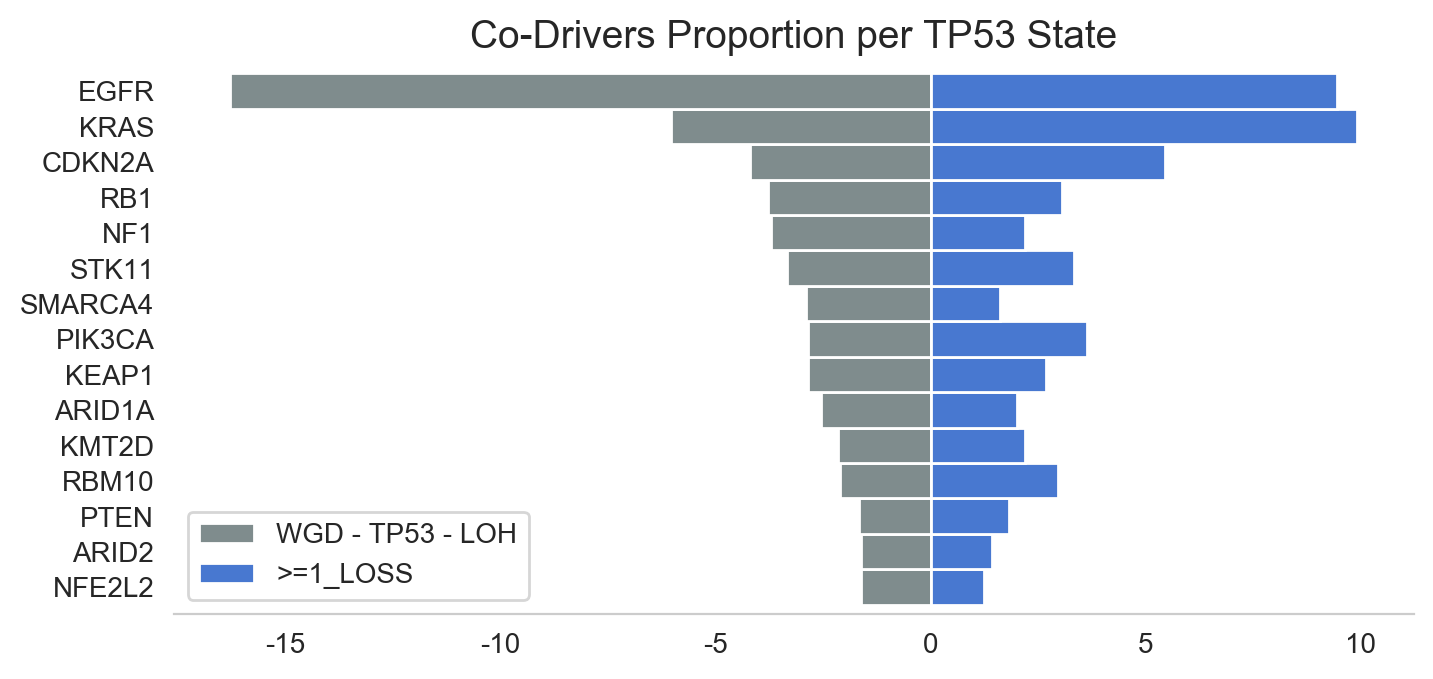

In [69]:
fig=plt.figure(figsize=(8,8))
ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

co_drivers_wgd_loss[['proportion_2', 'proportion_1']].head(15)[::-1].plot.barh(stacked=True, ax=ax, width=1, color = ['#7F8C8D',mc[0]])
ax.legend(['WGD - TP53 - LOH', '>=1_LOSS'], fontsize=10)
ax.set_title('Co-Drivers Proportion per TP53 State', fontsize=14)

plt.yticks(fontsize=10)
ax.set_ylabel('')
a=ax.get_xticks().tolist()
a = [-20, -15, -10, -5, 0, 5, 10, 15]
ax.set_xticklabels(a, fontsize=10)
plt.grid(b=None)

plt.show()

### Genome Instability Associated

In [61]:
def get_master_codrivers(master: pd.DataFrame, maf: pd.DataFrame, symbol: str):
    samples = master.Tumor_Id.tolist()
    samples_final = maf[maf.Tumor_Sample_Barcode.isin(samples)][maf['Hugo_Symbol'] == symbol].Tumor_Sample_Barcode.tolist()

    master_filtered = master[master.Tumor_Id.isin(samples_final)]
    
    return master_filtered

#### >=1_cnLOH

In [73]:
master_no_wgd_cancer_cnloh = master_no_wgd_cancer[master_no_wgd_cancer['tp53_group'] == '>=1_cnLOH']
master_APC = get_master_codrivers(master=master_no_wgd_cancer_cnloh,
                                   maf=maf_cohort_nowgd,
                                   symbol='APC')

master_KRAS = get_master_codrivers(master=master_no_wgd_cancer_cnloh,
                                   maf=maf_cohort_nowgd,
                                   symbol='KRAS')

master_no_wgd_cancer_cnloh['data'] = '>=1_cnLOH'
master_APC['data'] = 'APC'
master_KRAS['data'] = 'KRAS'
master_PIK3CA['data'] = 'PIK3CA'

masters = [master_no_wgd_cancer_cnloh, master_APC, master_KRAS, master_PIK3CA]
allMasters = pd.concat(masters)

Text(0.5, 0, '')

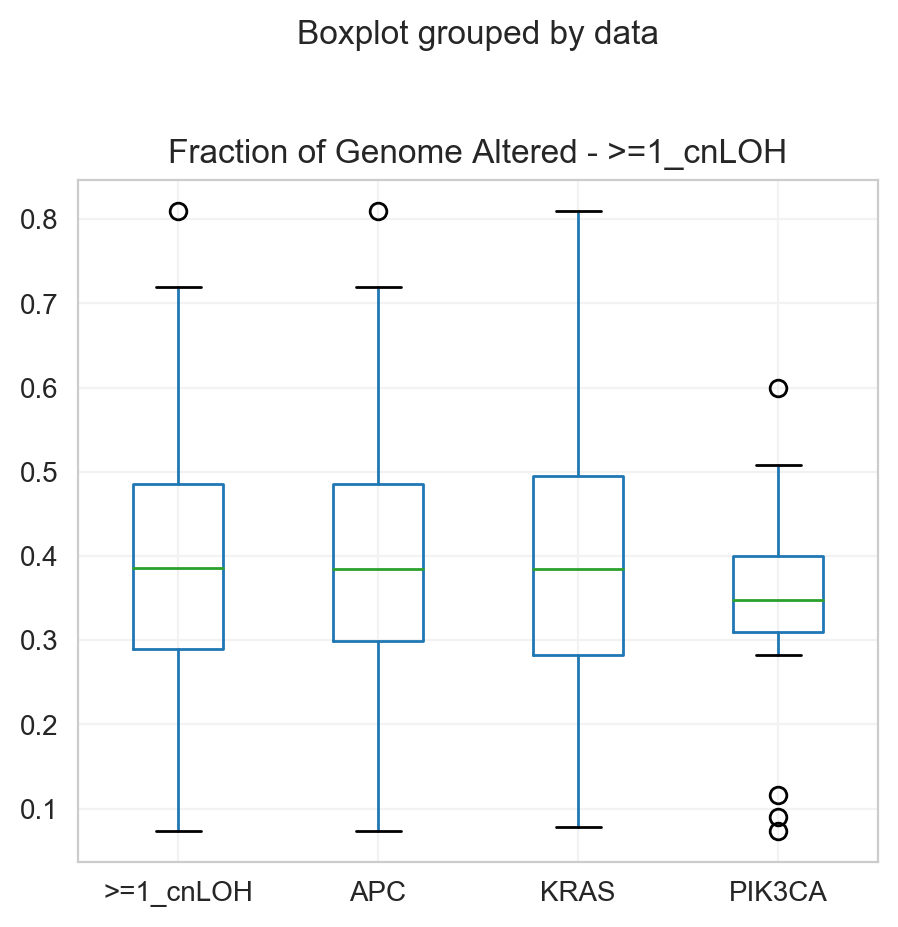

In [74]:
fig=plt.figure(figsize=(5,10))
ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)
allMasters[['frac_genome_altered', 'data']].boxplot(by="data", ax=ax)
ax.set_title('Fraction of Genome Altered - >=1_cnLOH')
ax.set_xlabel('')

#### >=1_LOSS

In [78]:
master_no_wgd_cancer_loss = master_no_wgd_cancer[master_no_wgd_cancer['tp53_group'] == '>=1_LOSS']
master_APC = get_master_codrivers(master=master_no_wgd_cancer_loss,
                                   maf=maf_cohort_nowgd,
                                   symbol='APC')

master_KRAS = get_master_codrivers(master=master_no_wgd_cancer_loss,
                                   maf=maf_cohort_nowgd,
                                   symbol='KRAS')

master_PIK3CA = get_master_codrivers(master=master_no_wgd_cancer_loss,
                                   maf=maf_cohort_nowgd,
                                   symbol='PIK3CA')

master_no_wgd_cancer_loss['data'] = '>=1_loss'
master_APC['data'] = 'APC'
master_KRAS['data'] = 'KRAS'
master_PIK3CA['data'] = 'PIK3CA'

masters = [master_no_wgd_cancer_loss, master_APC, master_KRAS, master_PIK3CA]
allMasters = pd.concat(masters)

Text(0.5, 0, '')

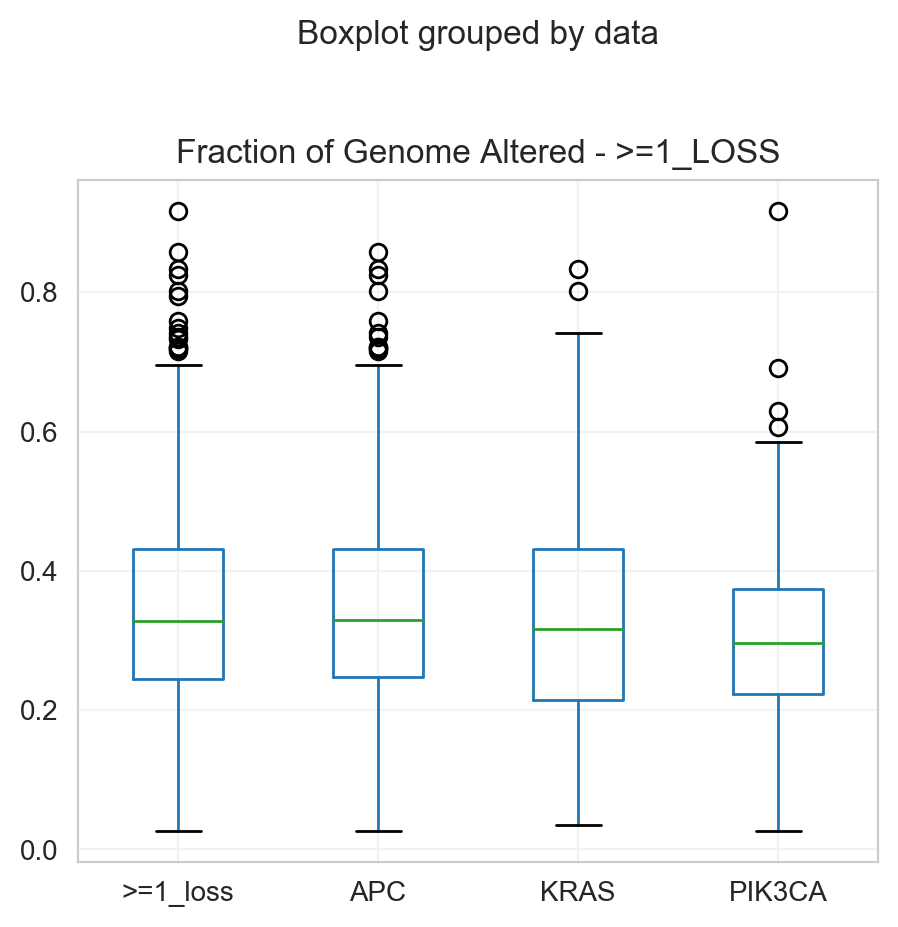

In [79]:
fig=plt.figure(figsize=(5,10))
ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)
allMasters[['frac_genome_altered', 'data']].boxplot(by="data", ax=ax)
ax.set_title('Fraction of Genome Altered - >=1_LOSS')
ax.set_xlabel('')

#### >1muts

In [77]:
master_no_wgd_cancer_muts = master_no_wgd_cancer[master_no_wgd_cancer['tp53_group'] == '>1muts']
master_APC = get_master_codrivers(master=master_no_wgd_cancer_muts,
                                   maf=maf_cohort_nowgd,
                                   symbol='APC')

master_KRAS = get_master_codrivers(master=master_no_wgd_cancer_muts,
                                   maf=maf_cohort_nowgd,
                                   symbol='KRAS')

master_KMT2D = get_master_codrivers(master=master_no_wgd_cancer_muts,
                                   maf=maf_cohort_nowgd,
                                   symbol='KMT2D')

master_RNF43 = get_master_codrivers(master=master_no_wgd_cancer_muts,
                                   maf=maf_cohort_nowgd,
                                   symbol='RNF43')

master_no_wgd_cancer_muts['data'] = '>1muts'
master_APC['data'] = 'APC'
master_KRAS['data'] = 'KRAS'
master_KMT2D['data'] = 'KMT2D'
master_RNF43['data'] = 'RNF43'

masters = [master_no_wgd_cancer_muts, master_APC, master_KRAS, master_KMT2D, master_RNF43]
allMasters = pd.concat(masters)

Text(0.5, 0, '')

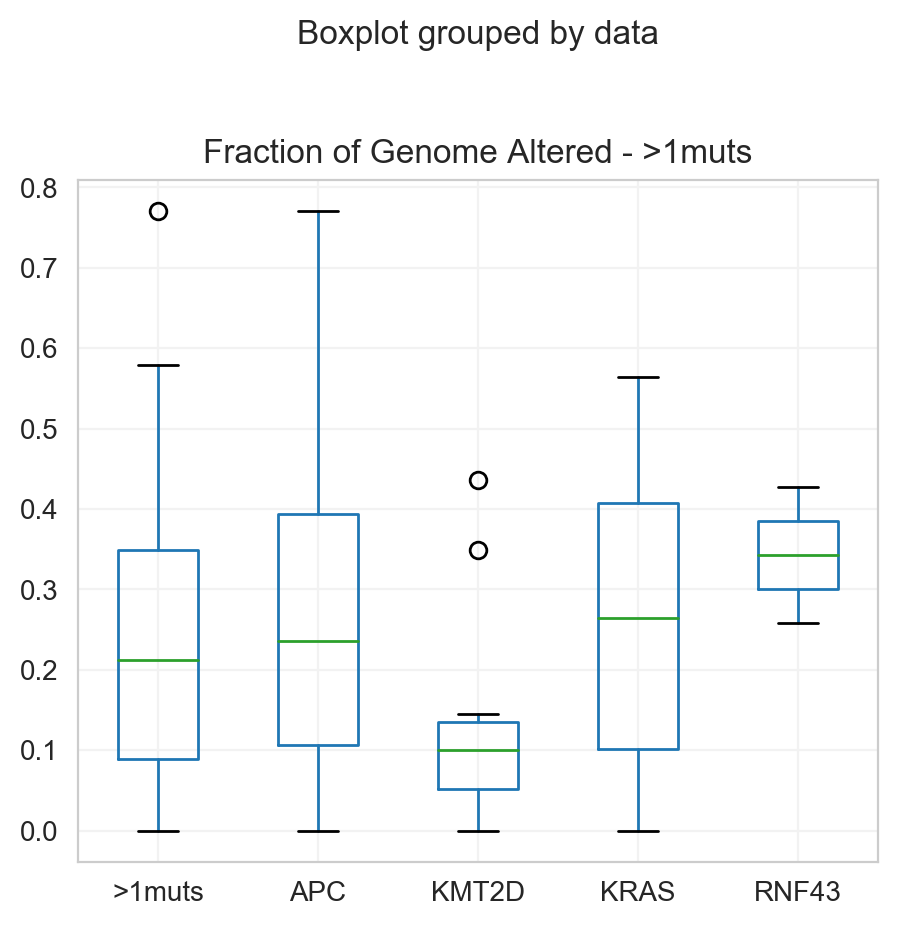

In [76]:
#### >1mutsfig=plt.figure(figsize=(5,10))
ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)
allMasters[['frac_genome_altered', 'data']].boxplot(by="data", ax=ax)
ax.set_title('Fraction of Genome Altered - >1muts')
ax.set_xlabel('')

#### 1_WILD_TYPE

In [ ]:
master_no_wgd_cancer_wt = master_no_wgd_cancer[master_no_wgd_cancer['tp53_group'] == '1_WILD_TYPE']
master_APC = get_master_codrivers(master=master_no_wgd_cancer_muts,
                                   maf=maf_cohort_nowgd,
                                   symbol='APC')

master_KRAS = get_master_codrivers(master=master_no_wgd_cancer_muts,
                                   maf=maf_cohort_nowgd,
                                   symbol='KRAS')

master_KMT2D = get_master_codrivers(master=master_no_wgd_cancer_muts,
                                   maf=maf_cohort_nowgd,
                                   symbol='KMT2D')

master_RNF43 = get_master_codrivers(master=master_no_wgd_cancer_muts,
                                   maf=maf_cohort_nowgd,
                                   symbol='RNF43')

master_no_wgd_cancer_muts['data'] = '>1muts'
master_APC['data'] = 'APC'
master_KRAS['data'] = 'KRAS'
master_KMT2D['data'] = 'KMT2D'
master_RNF43['data'] = 'RNF43'

masters = [master_no_wgd_cancer_muts, master_APC, master_KRAS, master_KMT2D, master_RNF43]
allMasters = pd.concat(masters)

In [ ]:
## Co Driver Analysis

codrivers_cancer = get_major_codrivers(master=master_no_wgd_cancer,
                    maf=maf_cohort_nowgd,
                    head=15)

codrivers_cancer_tp53 = get_major_codrivers(master=master_no_wgd_cancer[master_no_wgd_cancer['tp53_count'] >= 1],
                    maf=maf_cohort_nowgd,
                    head=15)

co_drivers = pd.merge(codrivers_cancer, codrivers_cancer_tp53, on='Hugo_Symbol')
co_drivers.columns = ['cancer', 'cancer_tp53']

co_drivers['ratio'] = co_drivers.apply(lambda x: 100*round(x.cancer_tp53/x.cancer, 4) , axis=1)
co_drivers = co_drivers.sort_values(by='ratio', ascending=False)

co_drivers

labels = []
for element in co_drivers.index.tolist():
    labels.append(element + ' ('+ str(int(co_drivers.loc[element]['cancer']))+')')

ax = sns.barplot(y=co_drivers.index, x='ratio',data=co_drivers[['ratio']], color='#7F8C8D', saturation=.2)
ax.set_yticklabels(labels)
ax.set_title('Co-Drivers Enrichment in TP53 State')

codrivers_cancer

labels = []
codrivers_cancer = get_major_codrivers(master=master_no_wgd_cancer,
                    maf=maf_cohort_nowgd,
                    head=15)

codrivers_cancer['proportion'] = codrivers_cancer.apply(lambda x: 100* round(x['count'] / codrivers_cancer.sum().values[0], 4), axis=1)

for element in codrivers_cancer.head(10).index.tolist():
    labels.append(element + ' ('+ str(int(codrivers_cancer.loc[element]['count']))+')')

ax = sns.barplot(y=codrivers_cancer.head(10).index, x='proportion',data=codrivers_cancer.head(10)[['proportion']], color='#7F8C8D', saturation=.2)
ax.set_yticklabels(labels)
ax.set_title('Co-Drivers Frequency in {}'.format(cancer))

### Co-Drivers per subgroup

co_drivers_cnloh_loss = create_co_drivers_table(master=master_no_wgd_cancer, 
                                                group_type='tp53_group',
                                                group_1='>=1_cnLOH',
                                                group_2='>=1_LOSS')
co_drivers_cnloh_loss

labels = []
for element in co_drivers_cnloh_loss.head(10).index.tolist():
    labels.append(element + ' ('+ str(int(co_drivers_cnloh_loss.loc[element]['count_x']))+')')

ax = sns.barplot(y=co_drivers_cnloh_loss.head(10).index, x='proportion_1',data=co_drivers_cnloh_loss.head(10)[['proportion_1']], color='#7F8C8D', saturation=.2)
ax.set_yticklabels(labels)
ax.set_title('Co-Drivers Frequency in {} - {}'.format(subgroup, cancer))

fig=plt.figure(figsize=(7,7))
ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

co_drivers_cnloh_loss[['proportion_1', 'proportion_2']].head(10)[::-1].plot.barh(stacked=True, ax=ax, width=1, color = [mc[4],mc[0]])
ax.legend(['>=1_cnLOH', '>=1_LOSS'], fontsize=10)
ax.set_title('Co-Drivers Proportion per TP53 State', fontsize=14)

plt.yticks(fontsize=10)
ax.set_ylabel('')
a=ax.get_xticks().tolist()
a = [-40, -30, -20, -10, 0, 10, 20, 30, 40, 50]
ax.set_xticklabels(a, fontsize=10)
plt.grid(b=None)

plt.show()

Proportion are the same in both groups

co_drivers_losses = create_co_drivers_table(master=master_no_wgd_cancer, 
                                                group_type='tp53_group',
                                                group_1='0_HETLOSS',
                                                group_2='>=1_LOSS')
co_drivers_losses

fig=plt.figure(figsize=(7,7))
ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

co_drivers_losses[['proportion_1', 'proportion_2']].head(10)[::-1].plot.barh(stacked=True, ax=ax, width=1, color = [mc[5],mc[0]])
ax.legend(['0_HETLOSS', '>=1_LOSS'], fontsize=10)
ax.set_title('Co-Drivers Proportion per TP53 State', fontsize=14)

plt.yticks(fontsize=10)
ax.set_ylabel('')
a=ax.get_xticks().tolist()
a = [-40, -30, -20, -10, 0, 10, 20, 30, 40]
ax.set_xticklabels(a, fontsize=10)
plt.grid(b=None)

plt.show()

Same proportions, enrichment in **APC** and **KRAS**

---

co_drivers_mult_cnloh = create_co_drivers_table(master=master_no_wgd_cancer, 
                                                group_type='tp53_group',
                                                group_1='>1muts',
                                                group_2='>=1_cnLOH')
co_drivers_mult_cnloh

get_major_codrivers(master=master_no_wgd_cancer[master_no_wgd_cancer['tp53_group'] == '>1muts'],
                    maf=maf_cohort_nowgd,
                    head=100)

fig=plt.figure(figsize=(10,10))
ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

co_drivers_mult_cnloh[['proportion_1', 'proportion_2']].head(20)[::-1].plot.barh(stacked=True, ax=ax, width=1, color = [mc[3],mc[4]])
ax.legend(['>1muts', '>=1_cnLOH'], fontsize=10)
ax.set_title('Co-Drivers Proportion per TP53 State', fontsize=15)

plt.yticks(fontsize=10)
ax.set_ylabel('')
a=ax.get_xticks().tolist()
a = [-20, -10, 0, 10, 20, 30, 40]
ax.set_xticklabels(a, fontsize=10)
plt.grid(b=None)

plt.show()

* Same pattern of co-drivers distribution
---

co_drivers_wt_loss = create_co_drivers_table(master=master_no_wgd_cancer, 
                                                group_type='tp53_group',
                                                group_1='1_WILD_TYPE',
                                                group_2='>=1_LOSS')
co_drivers_wt_loss

fig=plt.figure(figsize=(10,10))
ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

co_drivers_wt_loss[['proportion_1', 'proportion_2']].head(20)[::-1].plot.barh(stacked=True, ax=ax, width=1, color = [mc[2],mc[0]])
ax.legend(['1_WILD_TYPE', '>=1_LOSS'], fontsize=10)
ax.set_title('Co-Drivers Proportion per TP53 State', fontsize=15)

plt.yticks(fontsize=10)
ax.set_ylabel('')
a=ax.get_xticks().tolist()
a = [-10, 0, 10, 20, 30, 40]
ax.set_xticklabels(a, fontsize=10)
plt.grid(b=None)

plt.show()

### Genome Instability Associated

def get_master_codrivers(master: pd.DataFrame, maf: pd.DataFrame, symbol: str):
    samples = master.Tumor_Id.tolist()
    samples_final = maf[maf.Tumor_Sample_Barcode.isin(samples)][maf['Hugo_Symbol'] == symbol].Tumor_Sample_Barcode.tolist()

    master_filtered = master[master.Tumor_Id.isin(samples_final)]
    
    return master_filtered

#### >=1_cnLOH

master_no_wgd_cancer_cnloh = master_no_wgd_cancer[master_no_wgd_cancer['tp53_group'] == '>=1_cnLOH']
master_APC = get_master_codrivers(master=master_no_wgd_cancer_cnloh,
                                   maf=maf_cohort_nowgd,
                                   symbol='APC')

master_KRAS = get_master_codrivers(master=master_no_wgd_cancer_cnloh,
                                   maf=maf_cohort_nowgd,
                                   symbol='KRAS')

master_no_wgd_cancer_cnloh['data'] = '>=1_cnLOH'
master_APC['data'] = 'APC'
master_KRAS['data'] = 'KRAS'
master_PIK3CA['data'] = 'PIK3CA'

masters = [master_no_wgd_cancer_cnloh, master_APC, master_KRAS, master_PIK3CA]
allMasters = pd.concat(masters)

fig=plt.figure(figsize=(5,10))
ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)
allMasters[['frac_genome_altered', 'data']].boxplot(by="data", ax=ax)
ax.set_title('Fraction of Genome Altered - >=1_cnLOH')
ax.set_xlabel('')

#### >=1_LOSS

master_no_wgd_cancer_loss = master_no_wgd_cancer[master_no_wgd_cancer['tp53_group'] == '>=1_LOSS']
master_APC = get_master_codrivers(master=master_no_wgd_cancer_loss,
                                   maf=maf_cohort_nowgd,
                                   symbol='APC')

master_KRAS = get_master_codrivers(master=master_no_wgd_cancer_loss,
                                   maf=maf_cohort_nowgd,
                                   symbol='KRAS')

master_PIK3CA = get_master_codrivers(master=master_no_wgd_cancer_loss,
                                   maf=maf_cohort_nowgd,
                                   symbol='PIK3CA')

master_no_wgd_cancer_loss['data'] = '>=1_loss'
master_APC['data'] = 'APC'
master_KRAS['data'] = 'KRAS'
master_PIK3CA['data'] = 'PIK3CA'

masters = [master_no_wgd_cancer_loss, master_APC, master_KRAS, master_PIK3CA]
allMasters = pd.concat(masters)

fig=plt.figure(figsize=(5,10))
ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)
allMasters[['frac_genome_altered', 'data']].boxplot(by="data", ax=ax)
ax.set_title('Fraction of Genome Altered - >=1_LOSS')
ax.set_xlabel('')

#### >1muts

master_no_wgd_cancer_muts = master_no_wgd_cancer[master_no_wgd_cancer['tp53_group'] == '>1muts']
master_APC = get_master_codrivers(master=master_no_wgd_cancer_muts,
                                   maf=maf_cohort_nowgd,
                                   symbol='APC')

master_KRAS = get_master_codrivers(master=master_no_wgd_cancer_muts,
                                   maf=maf_cohort_nowgd,
                                   symbol='KRAS')

master_KMT2D = get_master_codrivers(master=master_no_wgd_cancer_muts,
                                   maf=maf_cohort_nowgd,
                                   symbol='KMT2D')

master_RNF43 = get_master_codrivers(master=master_no_wgd_cancer_muts,
                                   maf=maf_cohort_nowgd,
                                   symbol='RNF43')

master_no_wgd_cancer_muts['data'] = '>1muts'
master_APC['data'] = 'APC'
master_KRAS['data'] = 'KRAS'
master_KMT2D['data'] = 'KMT2D'
master_RNF43['data'] = 'RNF43'

masters = [master_no_wgd_cancer_muts, master_APC, master_KRAS, master_KMT2D, master_RNF43]
allMasters = pd.concat(masters)

fig=plt.figure(figsize=(5,10))
ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)
allMasters[['frac_genome_altered', 'data']].boxplot(by="data", ax=ax)
ax.set_title('Fraction of Genome Altered - >1muts')
ax.set_xlabel('')

## CCF / VAF Analysis
Same here we take only samples with exactly 1 tp53 mutation (*master_hotspot*).

We have to define groups for CCF to see if there are differences between those groups. To have an idea of the CCF distribution we show here the distribution coming from the *cancer_panel*.

<img src='ccf.png' width=1000 length=1000>

We see that our tp53_ccf distribution is very high for all subgroups except for *1_WILD_TYPEAdd * and *>1muts*. *>=1_LOSS* is the biggest subgroup - by far - and has a very high CCF median.

It will be hard to cut the cohort based on the CCF. Let's try and see the size of the subcohorts:

In [81]:
master_ccf = master_no_wgd_cancer[(master_no_wgd_cancer['tp53_count'] == 1) | (master_no_wgd_cancer['tp53_group'] == '0_HETLOSS')]

In [82]:
thr_ccf_1 = 0.8 ; thr_ccf_2 = 0.9

def ccf_subgroup(x):
    if x.tp53_ccf_1 <= thr_ccf_1: return 'low'
    elif x.tp53_ccf_1 <= thr_ccf_2: return 'medium'
    elif x.tp53_ccf_1 > thr_ccf_2: return 'high'

master_ccf['ccf_group'] = master_ccf.apply(ccf_subgroup, axis=1)
get_groupby(master_ccf, 'ccf_group', 'count')

,count
ccf_group,
high,382
low,131
medium,78


In [83]:
thr_vaf_1 = 0.3 ; thr_vaf_2 = 0.4

def vaf_subgroup(x):
    if x.tp53_vaf_1 <= thr_vaf_1: return 'low'
    elif x.tp53_vaf_1 <= thr_vaf_2: return 'medium'
    elif x.tp53_vaf_1 > thr_vaf_2: return 'high'

master_ccf['vaf_group'] = master_ccf.apply(vaf_subgroup, axis=1)       
get_groupby(master_ccf, 'vaf_group', 'count')

,count
vaf_group,
high,101
low,432
medium,65


### VAF Analysis

#### No VAF Cut

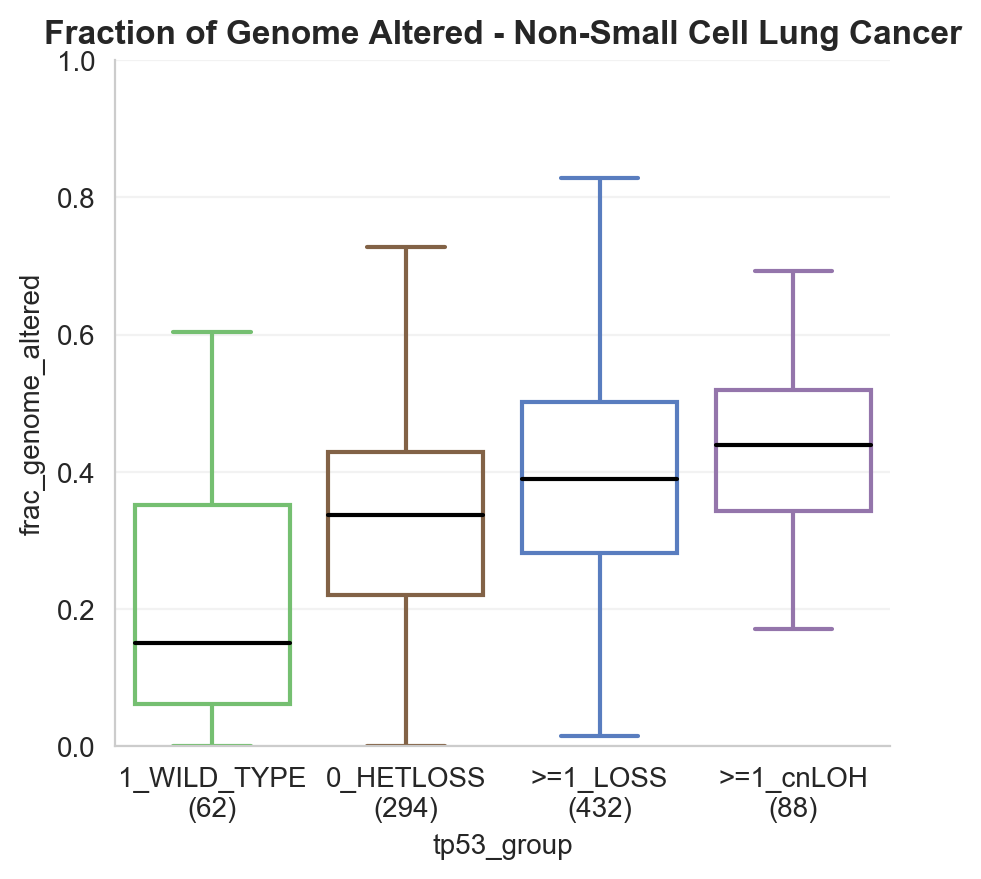

,0,1,2
0,,size,frac_genome_altered
1,0_HETLOSS,294,0.3375
2,1_WILD_TYPE,62,0.1505
3,,Statistics,p-value
4,,5.34833,8.87716e-08


In [61]:
fig, ax = boxplot_sampletype(df=master_ccf,
                  group='tp53_group',
                  palette=palette,
                  order=['1_WILD_TYPE','0_HETLOSS', '>=1_LOSS', '>=1_cnLOH'],
                  metrics='frac_genome_altered',
                  figsize=(5,10),
                  title='Fraction of Genome Altered - {}'.format(cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_ccf,
               group='tp53_group',
               metrics='frac_genome_altered',
               group_list=['0_HETLOSS', '1_WILD_TYPE'])

#### Low VAF

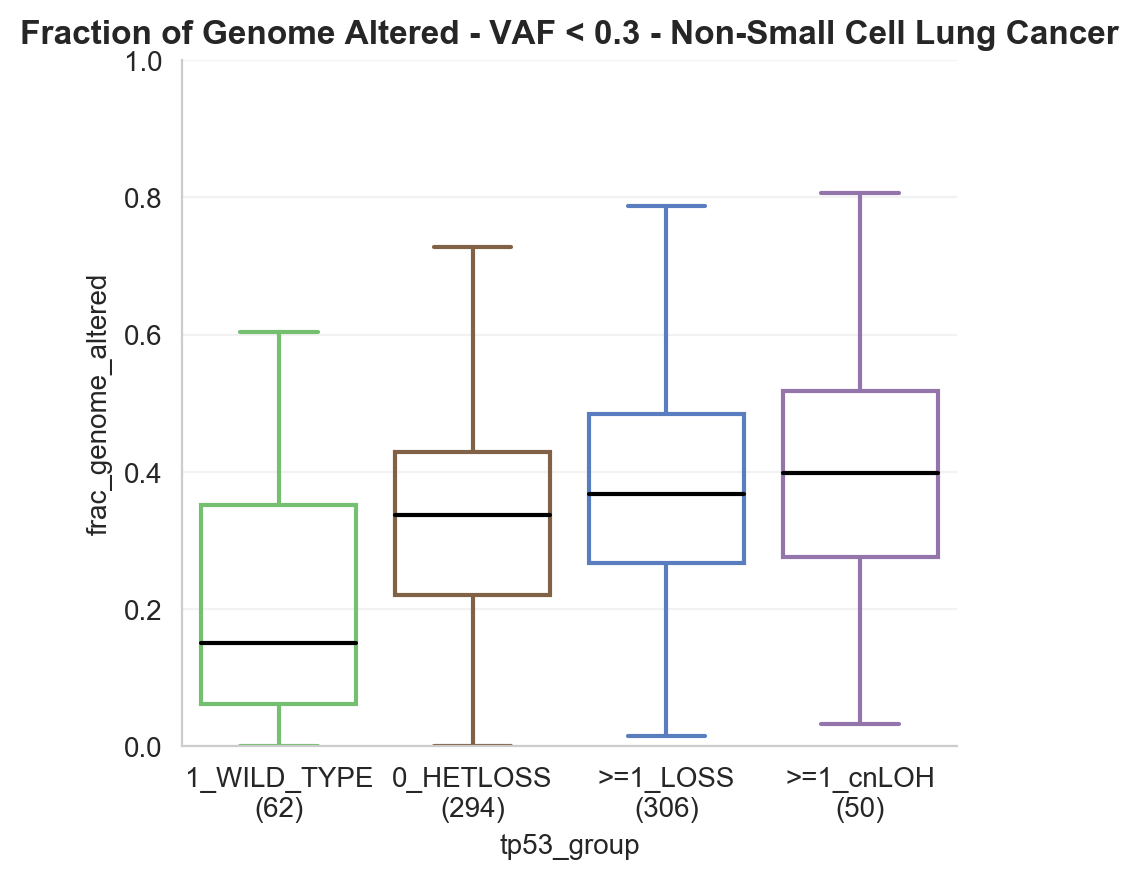

,0,1,2
0,,size,frac_genome_altered
1,1_WILD_TYPE,62,0.1505
2,>=1_LOSS,306,0.368
3,,Statistics,p-value
4,,-6.66275,2.68756e-11


In [62]:
master_low = master_ccf[(master_ccf['vaf_group'] == 'low') | (master_ccf['tp53_group'] == '0_HETLOSS')]

fig, ax = boxplot_sampletype(df=master_low,
                  group='tp53_group',
                  palette=palette,
                  order=['1_WILD_TYPE','0_HETLOSS', '>=1_LOSS', '>=1_cnLOH'],
                  metrics='frac_genome_altered',
                  figsize=(5,10),
                  title='Fraction of Genome Altered - VAF < {} - {}'.format(thr_vaf_1,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_low,
               group='tp53_group',
               metrics='frac_genome_altered',
               group_list=['1_WILD_TYPE', '>=1_LOSS'])

#### Medium VAF

KeyError: '1_WILD_TYPE'

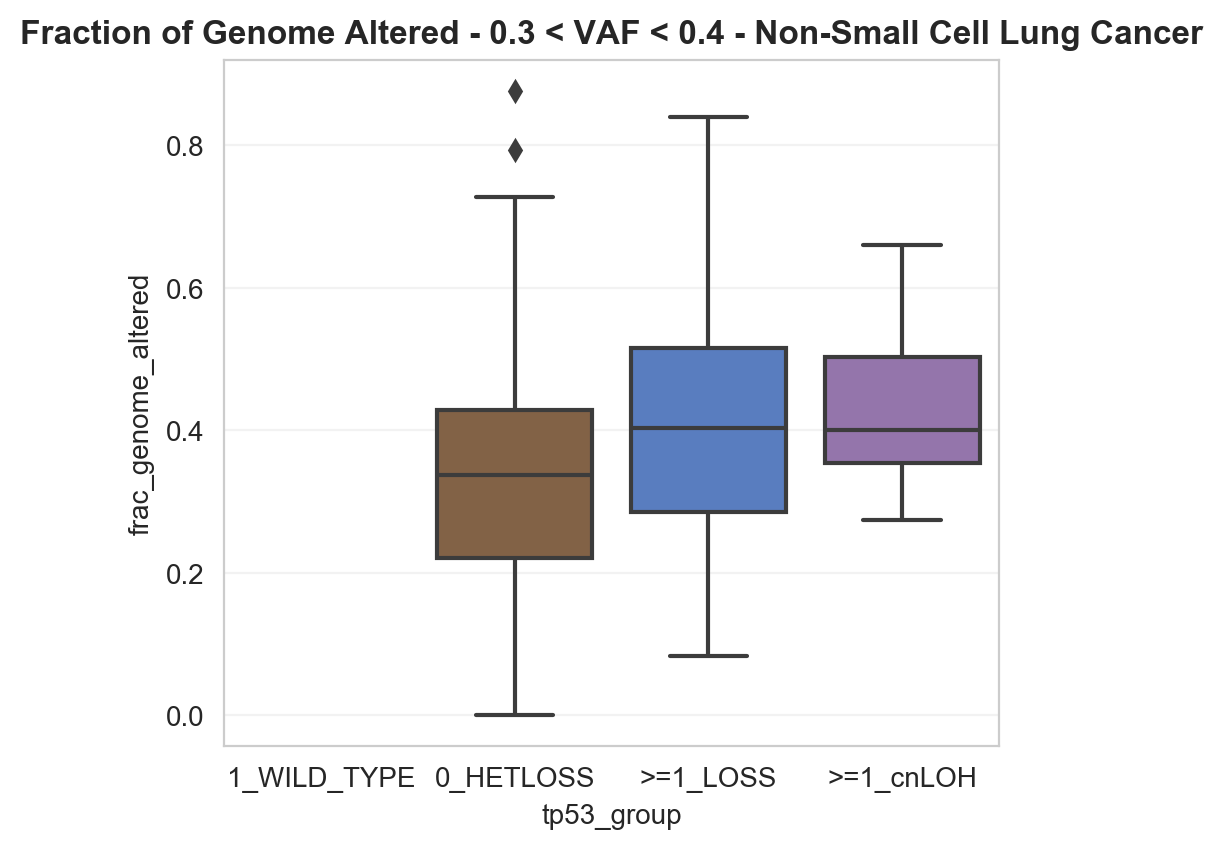

In [63]:
master_med = master_ccf[(master_ccf['vaf_group'] == 'medium') | (master_ccf['tp53_group'] == '0_HETLOSS')]

fig, ax = boxplot_sampletype(df=master_med,
                  group='tp53_group',
                  palette=palette,
                  order=['1_WILD_TYPE', '0_HETLOSS', '>=1_LOSS', '>=1_cnLOH'],
                  metrics='frac_genome_altered',
                  figsize=(5,10),
                  title='Fraction of Genome Altered - {} < VAF < {} - {}'.format(thr_vaf_1,thr_vaf_2,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_med,
               group='tp53_group',
               metrics='frac_genome_altered',
               group_list=['1_WILD_TYPE', '0_HETLOSS'])

#### High VAF

KeyError: '1_WILD_TYPE'

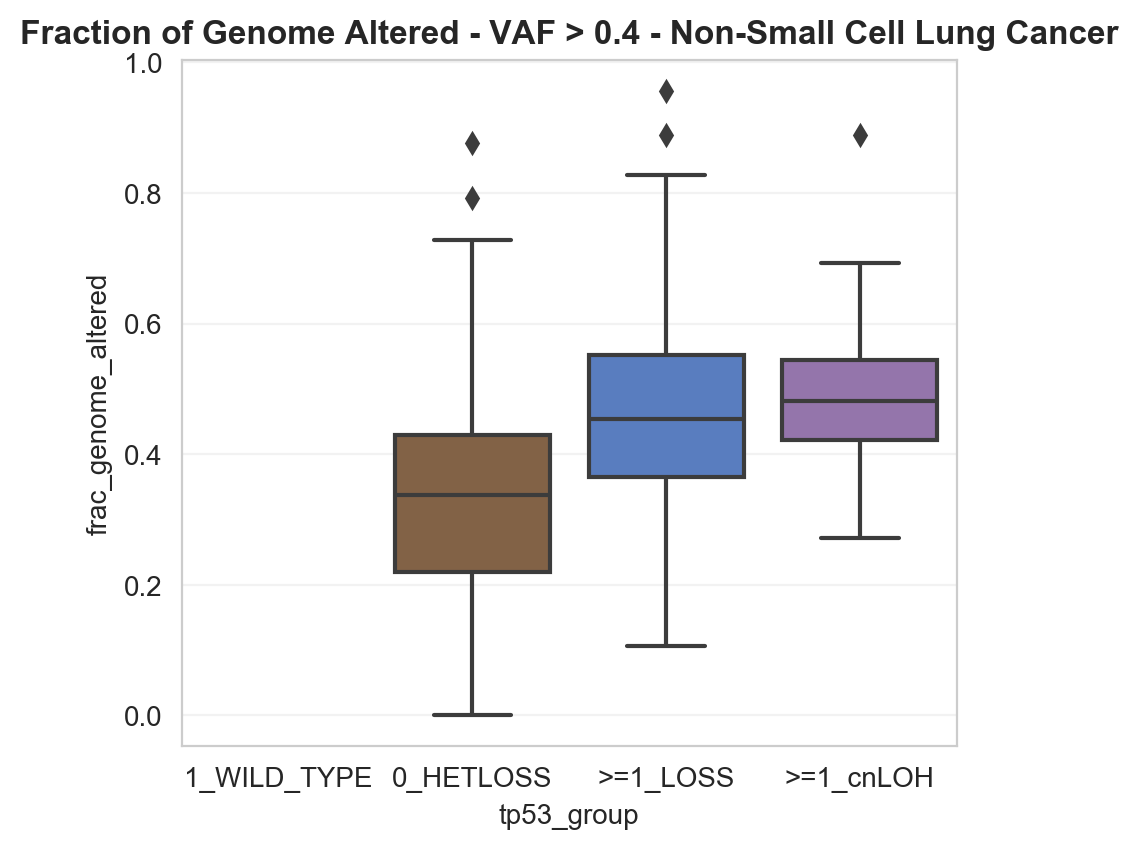

In [64]:
master_high = master_ccf[(master_ccf['vaf_group'] == 'high') | (master_ccf['tp53_group'] == '0_HETLOSS')]

fig, ax = boxplot_sampletype(df=master_high,
                  group='tp53_group',
                  palette=palette,
                  order=['1_WILD_TYPE', '0_HETLOSS', '>=1_LOSS', '>=1_cnLOH'],
                  metrics='frac_genome_altered',
                  figsize=(5,10),
                  title='Fraction of Genome Altered - VAF > {} - {}'.format(thr_vaf_2,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_high,
               group='tp53_group',
               metrics='frac_genome_altered',
               group_list=['1_WILD_TYPE', '0_HETLOSS'])

### CCF Analysis

#### No CCF Cut

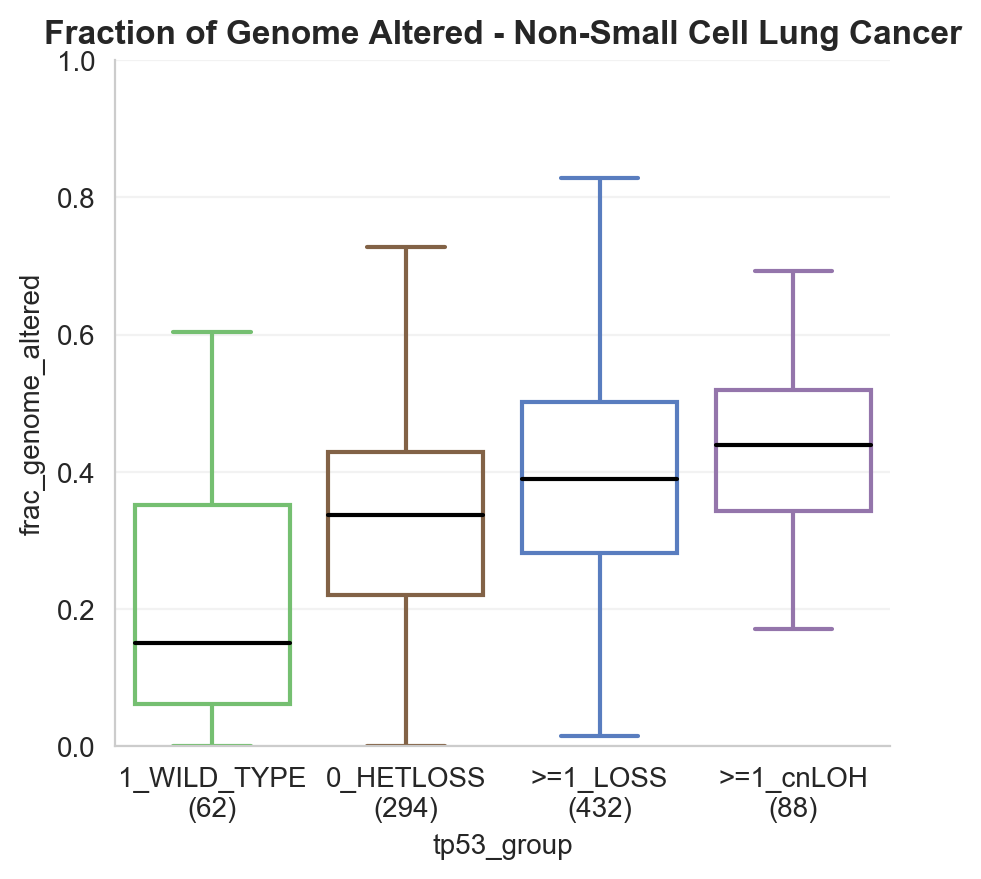

,0,1,2
0,,size,frac_genome_altered
1,0_HETLOSS,294,0.3375
2,1_WILD_TYPE,62,0.1505
3,,Statistics,p-value
4,,5.34833,8.87716e-08


In [65]:
fig, ax = boxplot_sampletype(df=master_ccf,
                  group='tp53_group',
                  palette=palette,
                  order=['1_WILD_TYPE','0_HETLOSS', '>=1_LOSS', '>=1_cnLOH'],
                  metrics='frac_genome_altered',
                  figsize=(5,10),
                  title='Fraction of Genome Altered - {}'.format(cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_ccf,
               group='tp53_group',
               metrics='frac_genome_altered',
               group_list=['0_HETLOSS', '1_WILD_TYPE'])

#### Low CCF

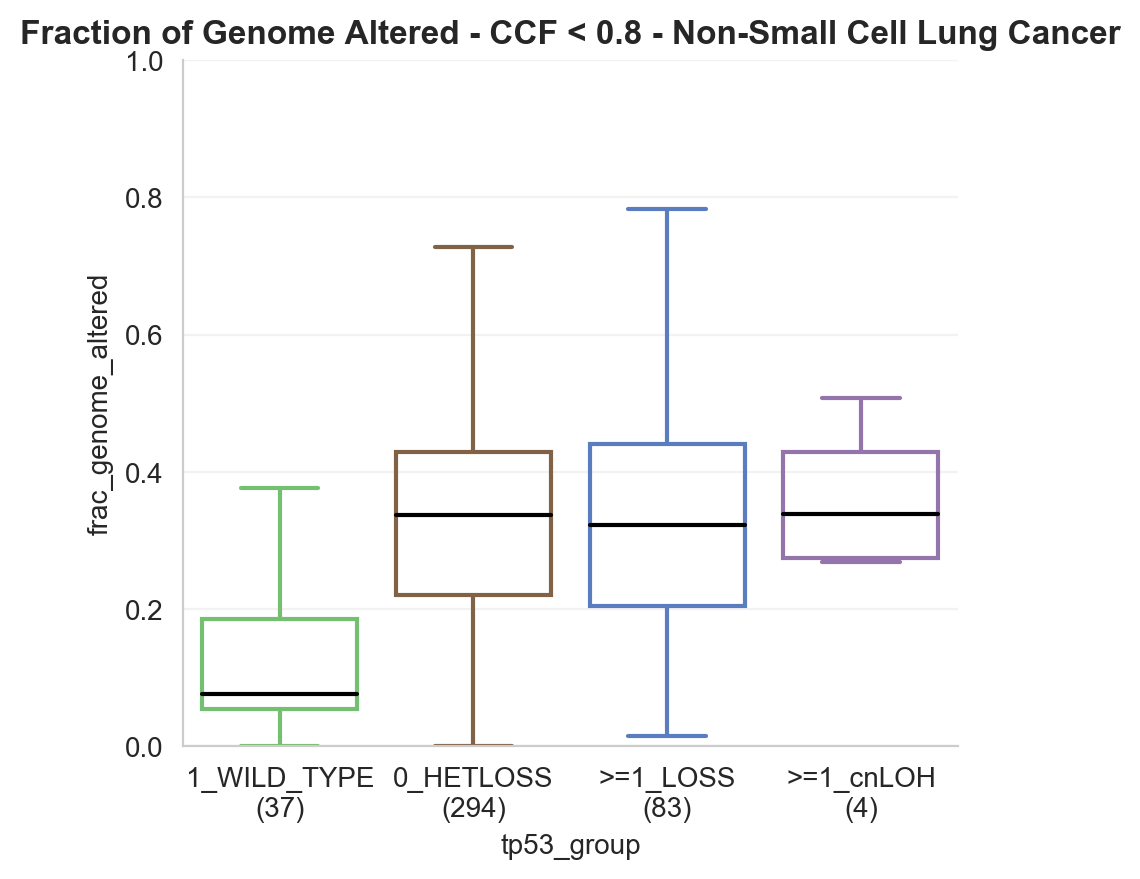

,0,1,2
0,,size,frac_genome_altered
1,1_WILD_TYPE,37,0.076
2,0_HETLOSS,294,0.3375
3,,Statistics,p-value
4,,-7.31139,2.64401e-13


In [66]:
master_low = master_ccf[(master_ccf['ccf_group'] == 'low') | (master_ccf['tp53_group'] == '0_HETLOSS')]

fig, ax = boxplot_sampletype(df=master_low,
                  group='tp53_group',
                  palette=palette,
                  order=['1_WILD_TYPE','0_HETLOSS', '>=1_LOSS', '>=1_cnLOH'],
                  metrics='frac_genome_altered',
                  figsize=(5,10),
                  title='Fraction of Genome Altered - CCF < {} - {}'.format(thr_ccf_1,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_low,
               group='tp53_group',
               metrics='frac_genome_altered',
               group_list=['1_WILD_TYPE', '0_HETLOSS'])

#### Medium CCF

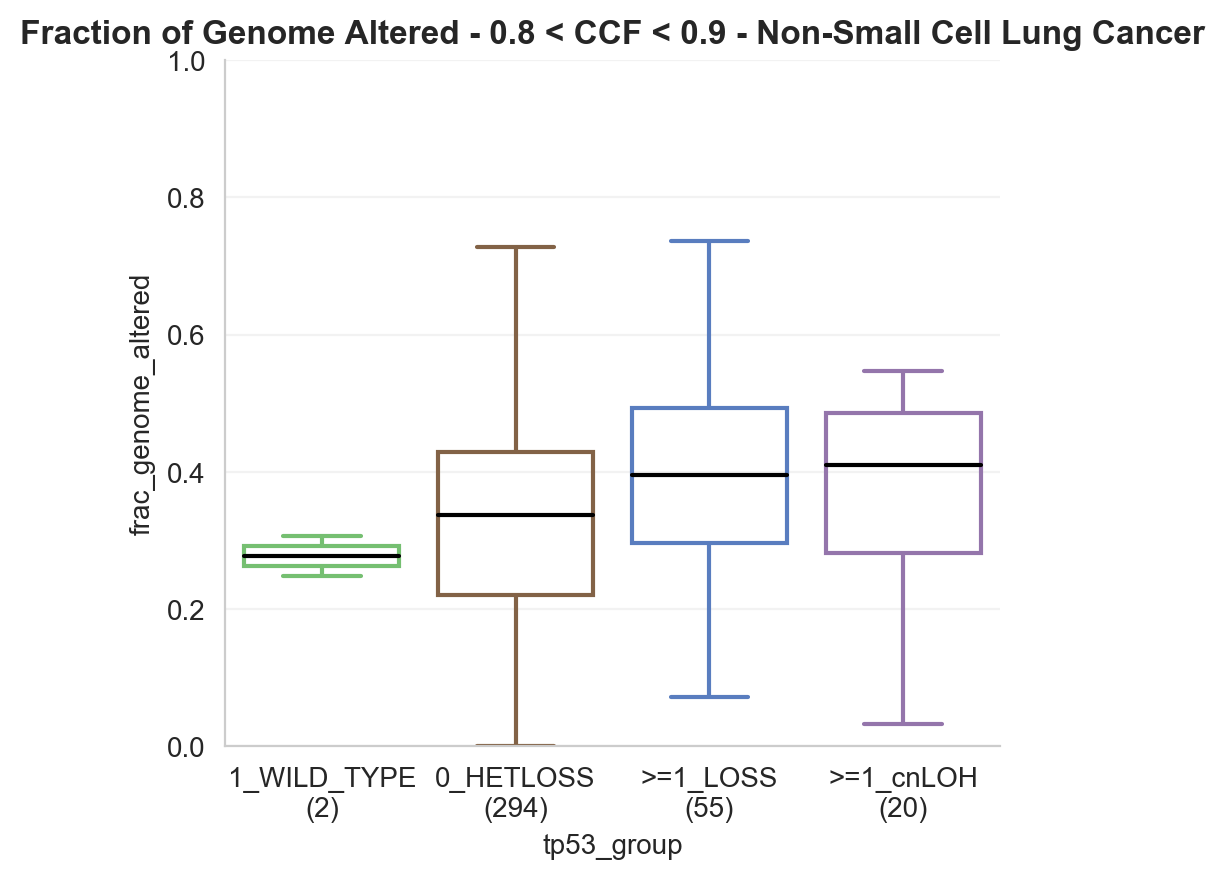

,0,1,2
0,,size,frac_genome_altered
1,1_WILD_TYPE,2,0.2775
2,0_HETLOSS,294,0.3375
3,,Statistics,p-value
4,,-0.663153,0.507233


In [67]:
master_med = master_ccf[(master_ccf['ccf_group'] == 'medium') | (master_ccf['tp53_group'] == '0_HETLOSS')]

fig, ax = boxplot_sampletype(df=master_med,
                  group='tp53_group',
                  palette=palette,
                  order=['1_WILD_TYPE', '0_HETLOSS', '>=1_LOSS', '>=1_cnLOH'],
                  metrics='frac_genome_altered',
                  figsize=(5,10),
                  title='Fraction of Genome Altered - {} < CCF < {} - {}'.format(thr_ccf_1,thr_ccf_2,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_med,
               group='tp53_group',
               metrics='frac_genome_altered',
               group_list=['1_WILD_TYPE', '0_HETLOSS'])

#### High CCF

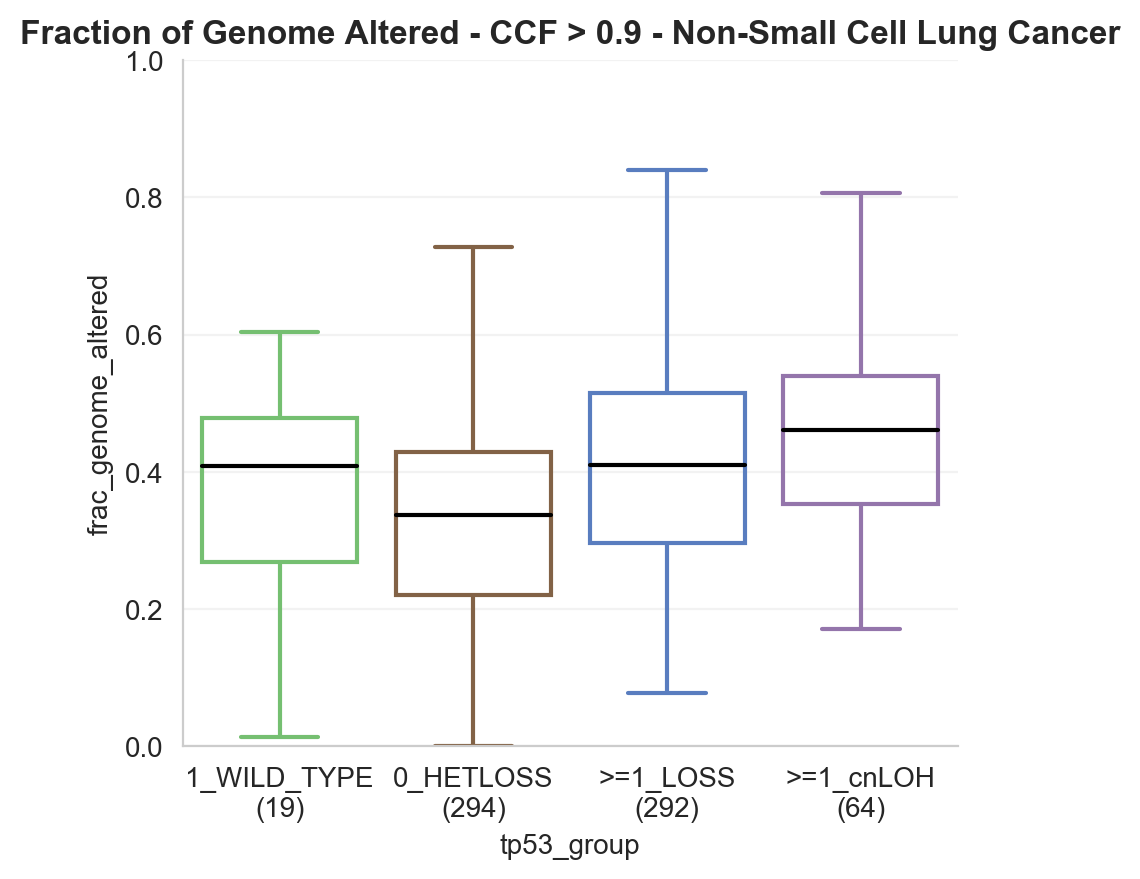

,0,1,2
0,,size,frac_genome_altered
1,1_WILD_TYPE,19,0.408
2,0_HETLOSS,294,0.3375
3,,Statistics,p-value
4,,1.12079,0.262375


In [84]:
master_high = master_ccf[(master_ccf['ccf_group'] == 'high') | (master_ccf['tp53_group'] == '0_HETLOSS')]

fig, ax = boxplot_sampletype(df=master_high,
                  group='tp53_group',
                  palette=palette,
                  order=['1_WILD_TYPE', '0_HETLOSS', '>=1_LOSS', '>=1_cnLOH'],
                  metrics='frac_genome_altered',
                  figsize=(5,10),
                  title='Fraction of Genome Altered - CCF > {} - {}'.format(thr_ccf_2,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_high,
               group='tp53_group',
               metrics='frac_genome_altered',
               group_list=['1_WILD_TYPE', '0_HETLOSS'])

let's check the hotspot distribution

In [86]:
get_hotspot_frac(df=master_high[master_high['tp53_group'] == '1_WILD_TYPE'],
                group_type=None,
                group=None)

,0,1,2
0,spot,#,frac
1,158,2,0.2705
2,248,2,0.394
3,273,2,0.249
4,nan,2,0.312
5,162,1,0.531
6,163,1,0.414
7,195,1,0.416
8,285,1,0.471
9,317,1,0.603


### Splitting on the different level of CCF / VAF

In [ ]:
fig, ax = boxplot_sampletype(df=master_hotspot,
                  group='vaf_group',
                  palette={'low': tab10[0] , 'medium': tab10[1], 'high':tab10[2]},
                  order=['low', 'medium', 'high'],
                  metrics='frac_genome_altered',
                  figsize=(3,10),
                  title='Fraction of Genome Altered - VAF levels - {}'.format(cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_hotspot,
               group='vaf_group',
               metrics='frac_genome_altered',
               group_list=['low', 'medium'])

In [ ]:
fig, ax = boxplot_sampletype(df=master_hotspot,
                  group='ccf_group',
                  palette={'low': tab10[0] , 'medium': tab10[1], 'high':tab10[2]},
                  order=['low', 'medium', 'high'],
                  metrics='frac_genome_altered',
                  figsize=(3,10),
                  title='Fraction of Genome Altered - CCF levels - {}'.format(cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_hotspot,
               group='ccf_group',
               metrics='frac_genome_altered',
               group_list=['low', 'medium'])

## Clinical Correlates

### Age

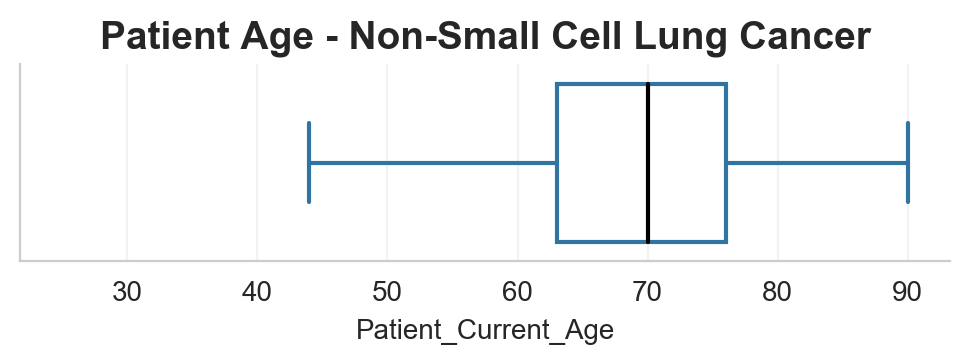

In [15]:
#### TP53 Residual Groups#fig=plt.figure(figsize=(10,3))
ax = plt.subplot2grid(shape=(4,1), loc=(0,0), colspan=1)

sns.boxplot(x='Patient_Current_Age',data=master_no_wgd_cancer, ax=ax).set_title('Patient Age - {}'.format(cancer), weight='bold', fontsize=14)


style(ax)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#### TP53 Residual Groups

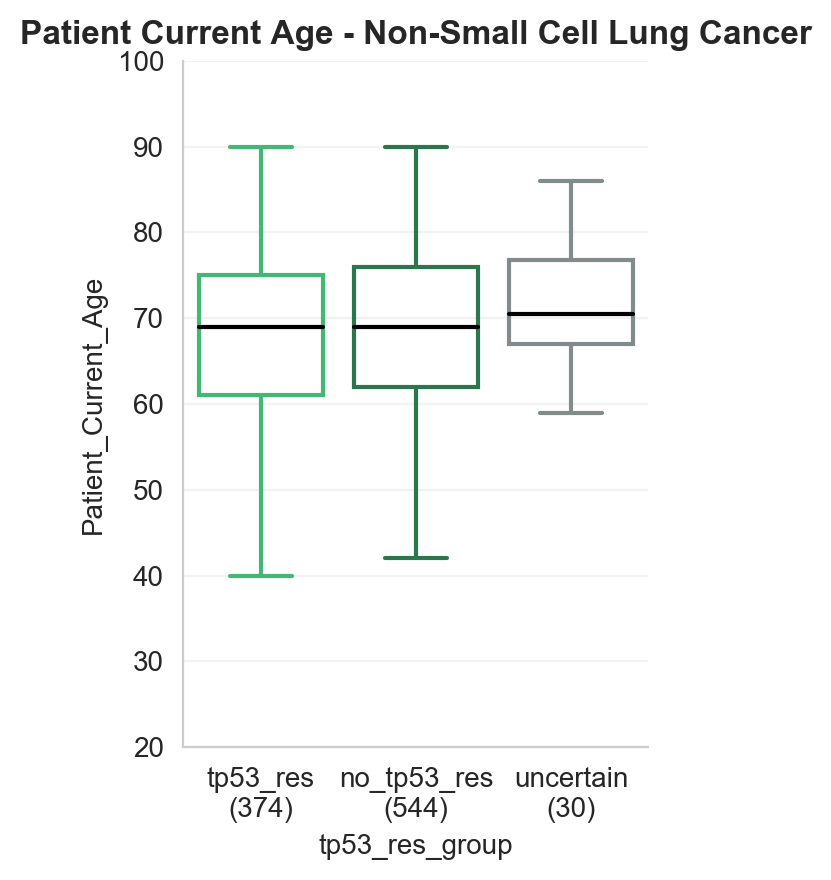

,0,1,2
0,,size,Patient_Current_Age
1,tp53_res,374,69
2,no_tp53_res,544,69
3,,Statistics,p-value
4,,-0.25777,0.796585


In [16]:
fig, ax = boxplot_sampletype(df=master_no_wgd_cancer,
                  group='tp53_res_group',
                  palette=palette_res,
                  order=res_group_list,
                  metrics='Patient_Current_Age',
                  figsize=(3,10),
                  title='Patient Current Age - {}'.format(cancer),
                  xlim=[20,100])
plt.show()

get_statistics(df=master_no_wgd_cancer,
               group='tp53_res_group',
               metrics='Patient_Current_Age',
               group_list=['tp53_res', 'no_tp53_res'])#### TP53 Subgroups

#### TP53 Subgroups

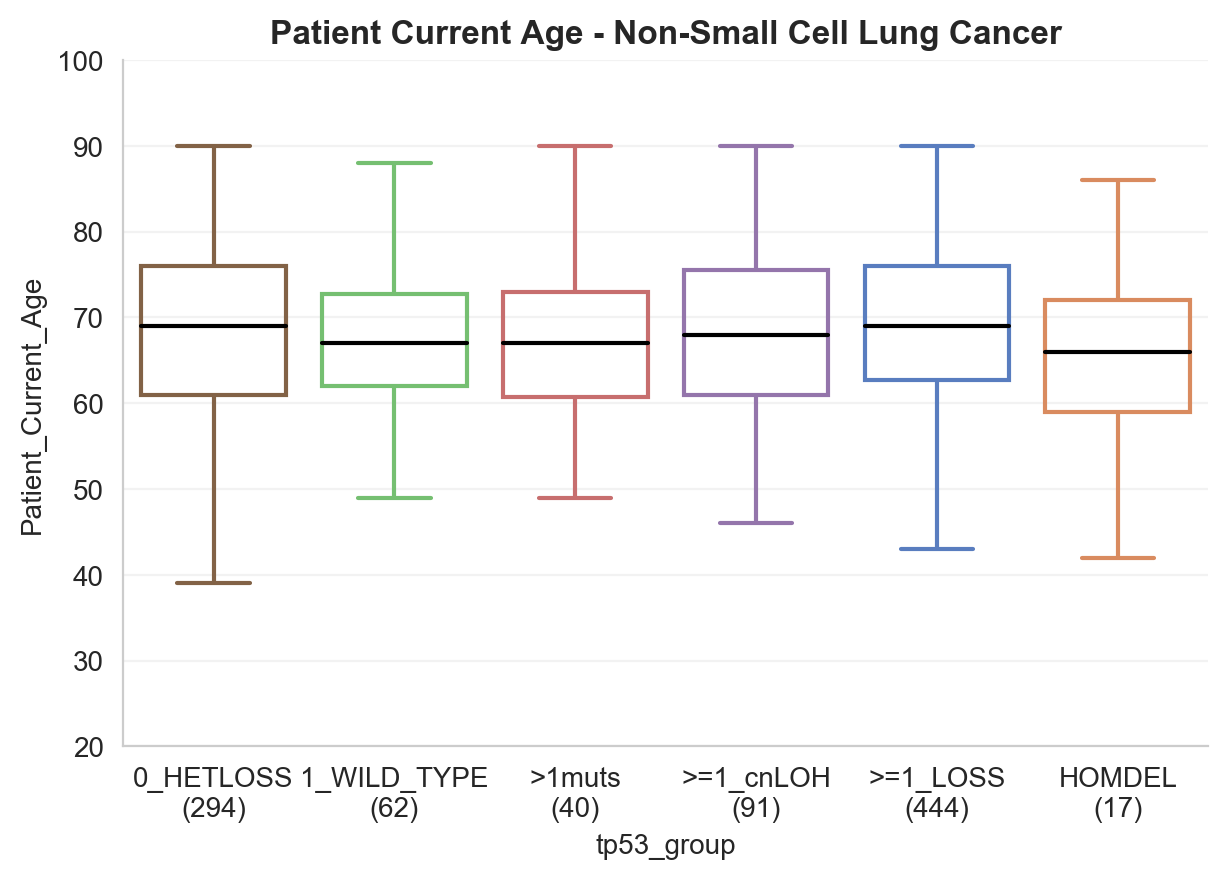

,0,1,2
0,,size,Patient_Current_Age
1,1_WILD_TYPE,62,67
2,>=1_cnLOH,91,68
3,,Statistics,p-value
4,,-0.533293,0.593831


In [17]:
fig, ax = boxplot_sampletype(df=master_no_wgd_cancer,
                  group='tp53_group',
                  palette=palette,
                  order=group_list,
                  metrics='Patient_Current_Age',
                  figsize=(7,10),
                  title='Patient Current Age - {}'.format(cancer),
                  xlim=[20,100])
plt.show()

get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='Patient_Current_Age',
               group_list=['1_WILD_TYPE', '>=1_cnLOH'])

### Sex

,count
Sex,
Female,1042
Male,733


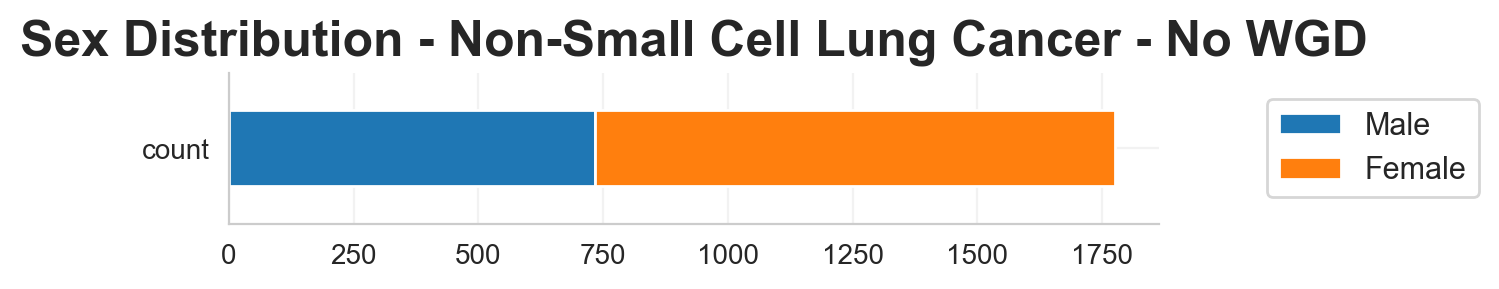

In [18]:
h = get_groupby(master_no_wgd_cancer,'Sex', 'count').sort_values(by='count', ascending=False)
display(h)

h = h.T
h = h[['Male', 'Female']]
fig = plt.figure(figsize=(6,1))
ax = plt.subplot()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

h_plot = h.plot(kind = 'barh', stacked=True, yticks=[], ax=ax)
ax.legend(['Male', 'Female'],loc='center left', bbox_to_anchor=(1.1, 0.5), fontsize=11)
ax.set_title('Sex Distribution - {} - No WGD'.format(cancer), weight='bold', fontsize=18)

plt.show()

### Survival Analysis

In [20]:
from lifelines import KaplanMeierFitter

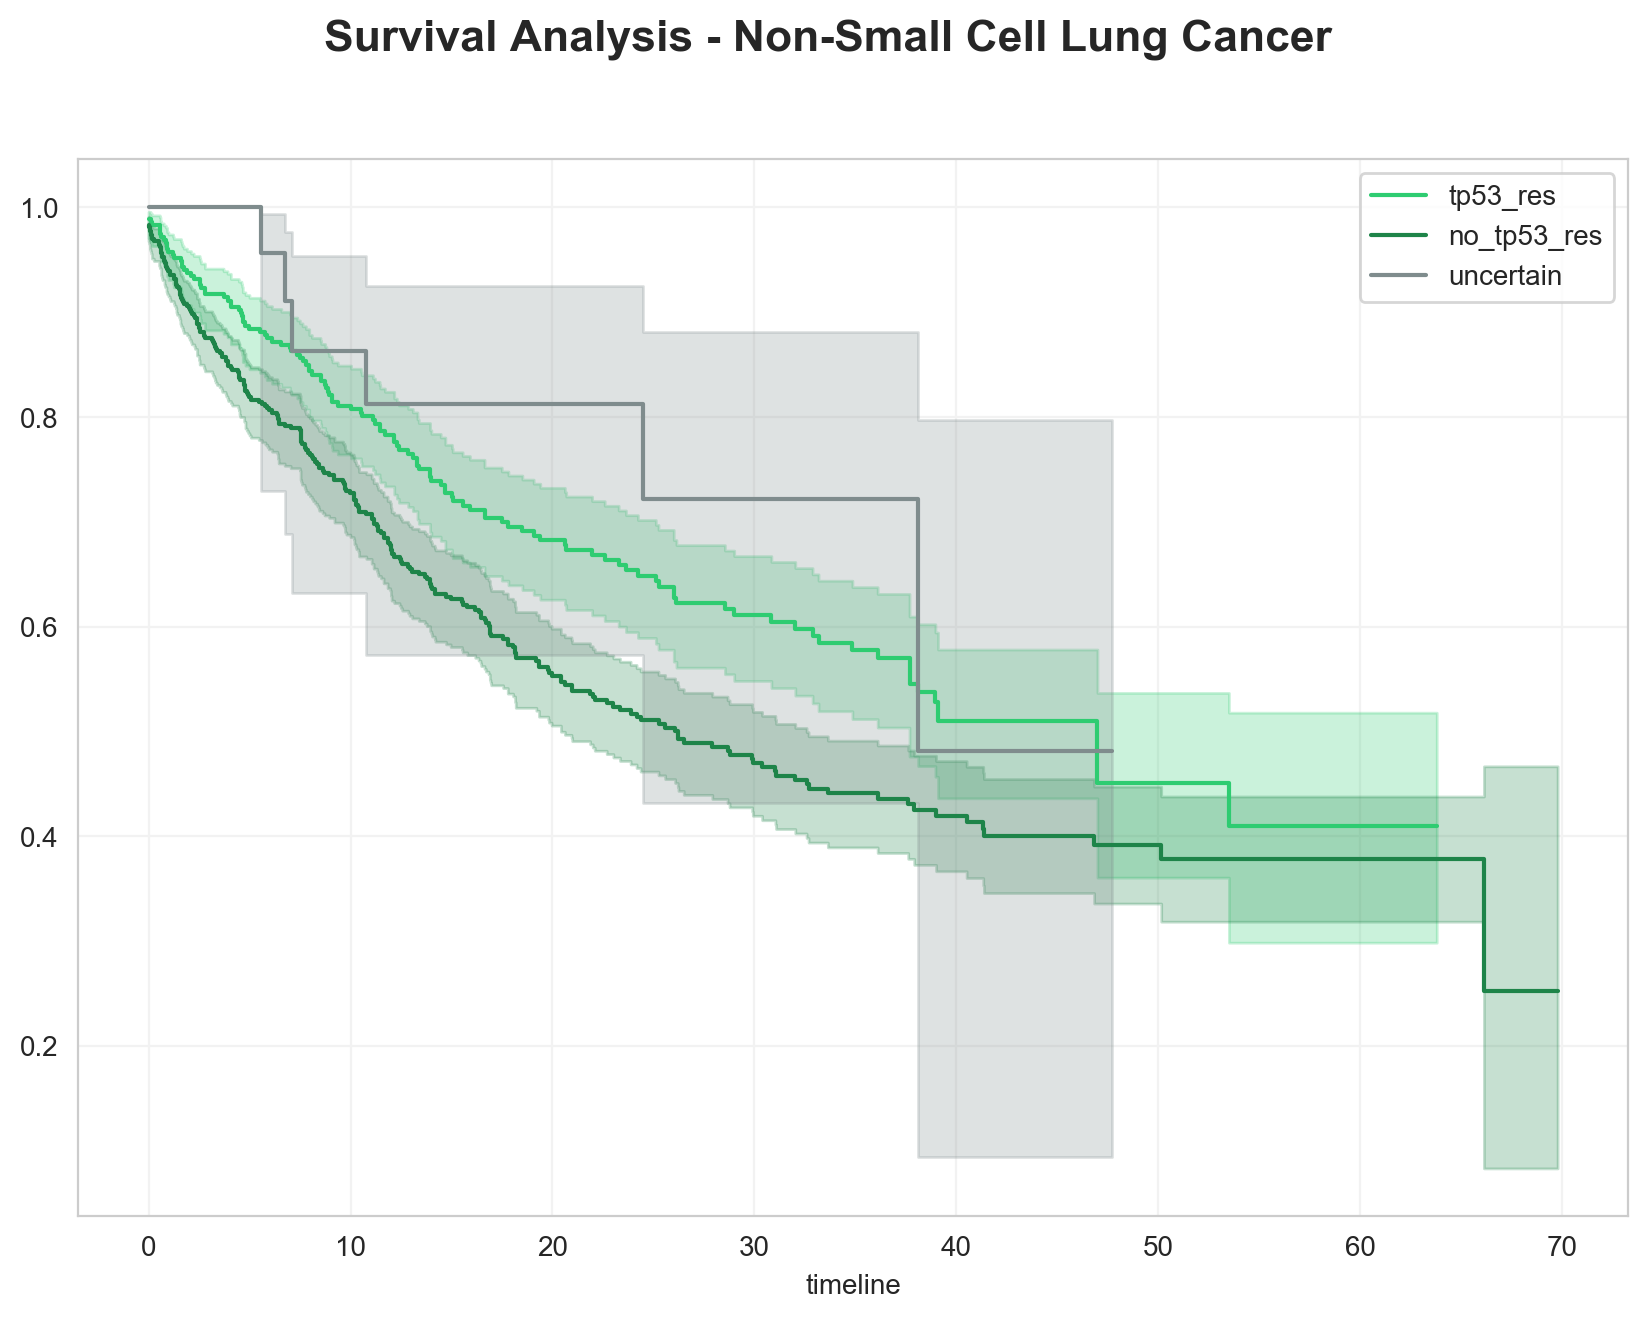

In [23]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
fig.suptitle('Survival Analysis - {}'.format(cancer), fontsize=16, weight='bold')
kmf = KaplanMeierFitter()

for group,i in zip(res_group_list, range(len(res_group_list))):
    data = master_no_wgd_cancer[master_no_wgd_cancer['tp53_res_group'] == group].dropna(subset=['Overall_Survival_Months', 'Overall_Survival_Status'])
    data['Overall Survival Status 0/1'] = data.apply(lambda x: 1 if x['Overall_Survival_Status'] == 'DECEASED' else 0, axis=1)
    kmf.fit(np.array(data['Overall_Survival_Months']), event_observed=np.array(data['Overall Survival Status 0/1']),  label= group)
    kmf.plot_survival_function(color = res_palette_list[i], ax=ax)
plt.show()

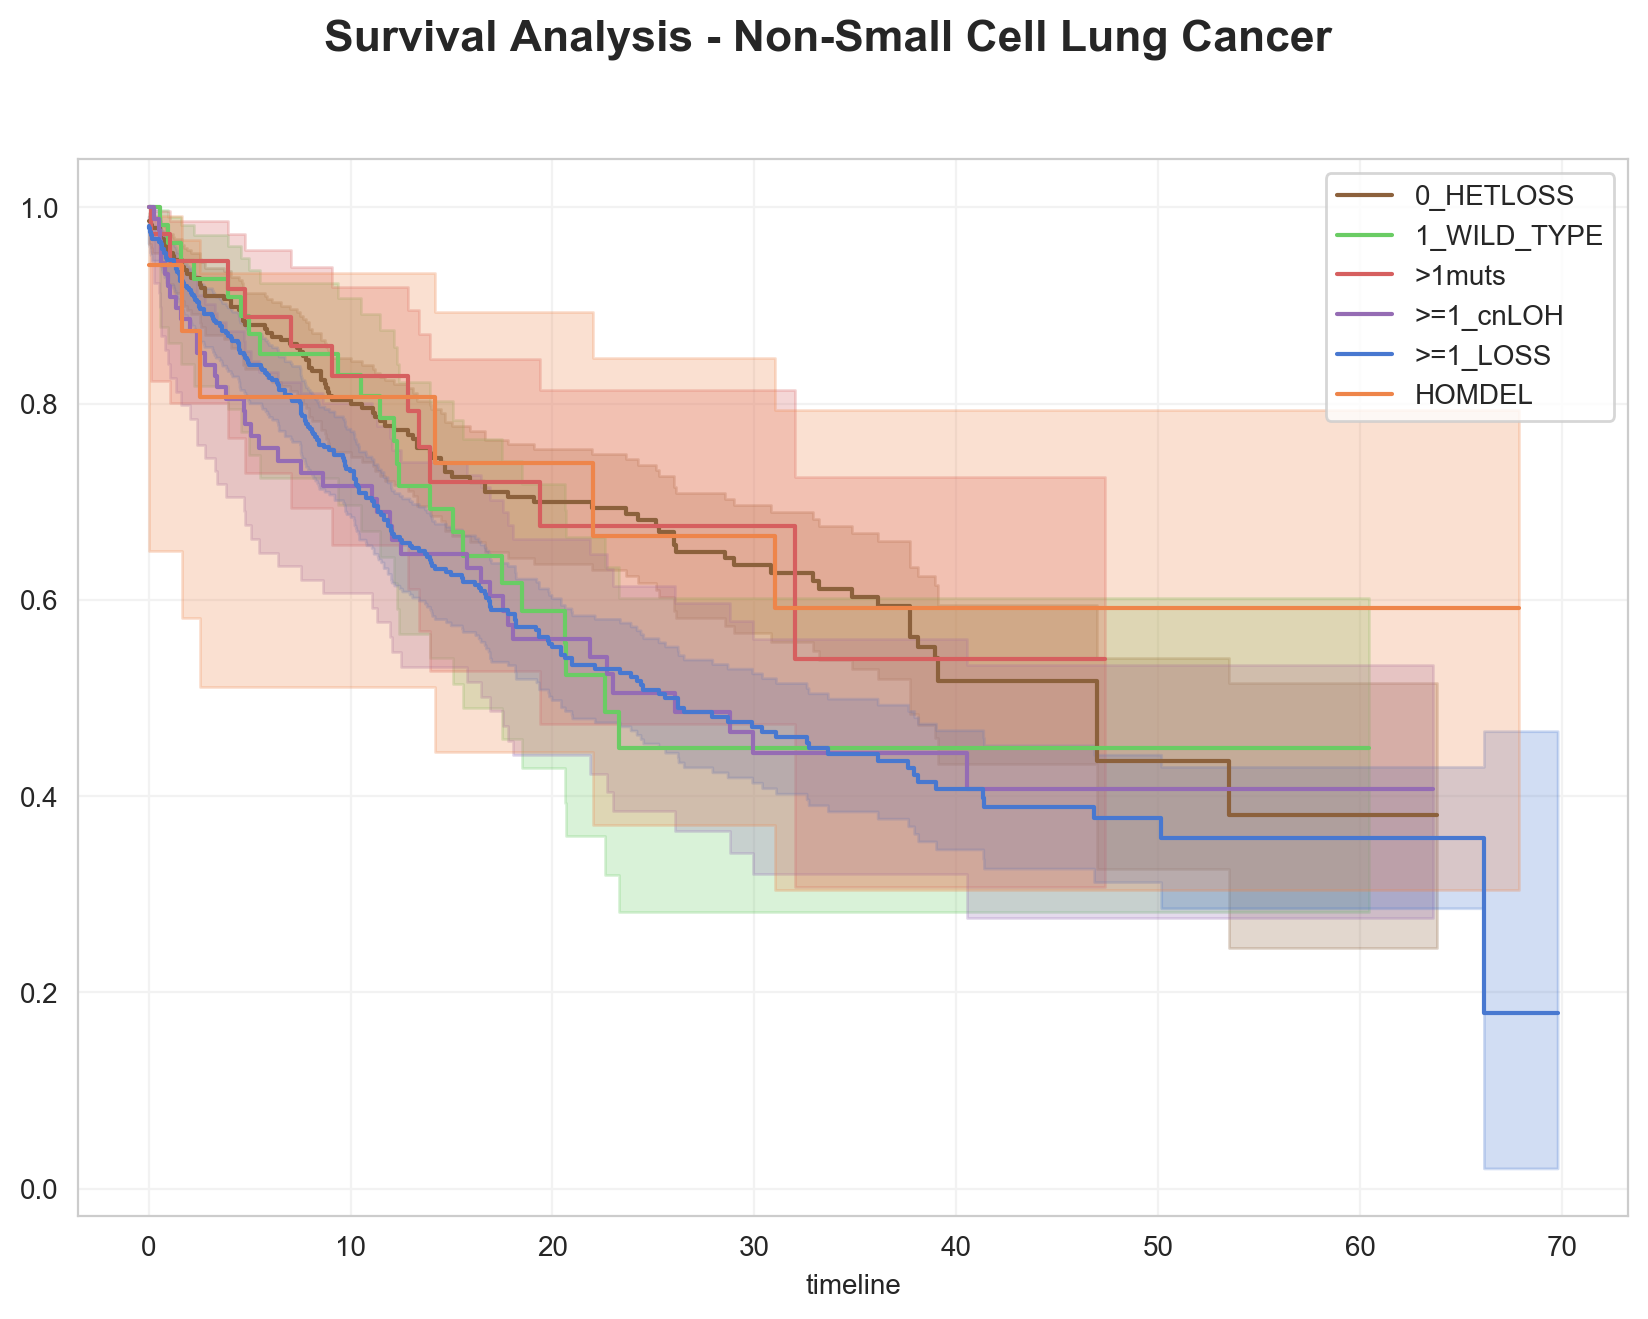

In [24]:

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
fig.suptitle('Survival Analysis - {}'.format(cancer), fontsize=16, weight='bold')
kmf = KaplanMeierFitter()

for group,i in zip(group_list, range(len(group_list))):
    data = master_no_wgd_cancer[master_no_wgd_cancer['tp53_group'] == group].dropna(subset=['Overall_Survival_Months', 'Overall_Survival_Status'])
    data['Overall Survival Status 0/1'] = data.apply(lambda x: 1 if x['Overall_Survival_Status'] == 'DECEASED' else 0, axis=1)
    kmf.fit(np.array(data['Overall_Survival_Months']), event_observed=np.array(data['Overall Survival Status 0/1']),  label= group)
    kmf.plot_survival_function(color = palette_list[i], ax=ax)
plt.show()